In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy.special import softmax
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics
from scipy import stats
import seaborn as sns

def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

def balanced_acc_5_cls(pred,true): 
    unique, counts = np.unique(true, return_counts=True)
    acc = 0
    for u in unique:
        pred_cls = pred[true==u]
        true_cls = true[true==u]
        acc+=metrics.accuracy_score(pred_cls,true_cls)
    #print(acc)
    return acc/unique.shape[0]

In [2]:
def get_labels_start_end_time(frame_wise_labels, bg_class=["background"]):
    labels = []
    starts = []
    ends = []
    last_label = frame_wise_labels[0]
    if frame_wise_labels[0] not in bg_class:
        labels.append(frame_wise_labels[0])
        starts.append(0)
    for i in range(len(frame_wise_labels)):
        if frame_wise_labels[i] != last_label:
            if frame_wise_labels[i] not in bg_class:
                labels.append(frame_wise_labels[i])
                starts.append(i)
            if last_label not in bg_class:
                ends.append(i)
            last_label = frame_wise_labels[i]
    if last_label not in bg_class:
        ends.append(i + 1)
    return labels, starts, ends

def removeDuplicates(S):
    S = list(S.rstrip())
    n = len(S)   
    if (n < 2) : 
        return S  
    j = 0
    for i in range(n):    
        if (S[j] != S[i]): 
            j += 1
            S[j] = S[i]   
    j += 1
    S = S[:j] 
    return ''.join(S)

def levenstein(p, y, norm=False):
    m_row = len(p)    
    n_col = len(y)
    D = np.zeros([m_row+1, n_col+1], np.float)
    for i in range(m_row+1):
        D[i, 0] = i
    for i in range(n_col+1):
        D[0, i] = i

    for j in range(1, n_col+1):
        for i in range(1, m_row+1):
            if y[j-1] == p[i-1]:
                D[i, j] = D[i-1, j-1]
            else:
                D[i, j] = min(D[i-1, j] + 1,
                              D[i, j-1] + 1,
                              D[i-1, j-1] + 1)
    
    if norm:
        score = (1 - D[-1, -1]/max(m_row, n_col)) * 100
    else:
        score = D[-1, -1]

    return score

def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)
#                 distance[cur_row_idx][j] = min(i_num, d_num)

    return distance[m % 2][n]

def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

def printChanges(s1, s2, dp, print_true = False): 
      
    i = len(s1) 
    j = len(s2) 
    deletions = 0
    insertions = 0
    substitutions = 0
    
    subs_for_margin = 0
    subs_for_middle = 0
    
    ins_for_margin = 0
    ins_for_middle = 0
    
    dels_for_margin = 0
    dels_for_middle = 0
    
    rt_margin = 0
    lt_margin = 0
    
    all_subs = []
    all_insertions = []
    all_deletions = []
      
   # Check till the end  
    while(i > 0 and j > 0): 
#         print('i=',i)
#         print('j=',j)
#         print('==')
          
        # If characters are same  
        if s1[i - 1] == s2[j - 1]: 
            i -= 1
            j -= 1
            if (s2[j-1]==s2[0]):
                lt_margin = 1
            if (s2[j-1]==s2[-1]):
                rt_margin = 1
                
        # Replace 
        elif dp[i][j] == dp[i - 1][j - 1] + 1:
            if print_true:
                print("change", s1[i - 1], 
                          "to", s2[j - 1])
            all_subs.append(s1[i - 1]+" to "+s2[j - 1])
            if (s2[j-1] == s2[-1]) or (s2[j-1]==s2[0]):
                subs_for_margin += 1
                if s2[j-1] == s2[-1]:
                    rt_margin = 1
                else:
                    lt_margin = 1
            else:
                subs_for_middle += 1
            j -= 1
            i -= 1
            substitutions += 1
            
        # Add 
        elif dp[i][j] == dp[i][j - 1] + 1:
            if print_true:
                print("Add", s2[j - 1])
            all_insertions.append(s2[j - 1])
            if (s2[j-1] == s2[-1]) or (s2[j-1]==s2[0]):
                ins_for_margin += 1
                if s2[j-1] == s2[-1]:
                    rt_margin = 1
                else:
                    lt_margin = 1
            else:
                ins_for_middle += 1
            j -= 1
            insertions += 1
        
        # Delete 
        elif dp[i][j] == dp[i - 1][j] + 1: 
            if print_true:
                print("Delete", s1[i - 1]) 
            all_deletions.append(s1[i - 1])
            i -= 1
            deletions += 1
            if (lt_margin == 0) and (rt_margin == 0):
                dels_for_margin += 1
            elif (lt_margin == 1) and (rt_margin == 1):
                dels_for_margin += 1
            else:
                dels_for_middle += 1
                
        
        elif i==0 and j==0:
            break
    
    if i == 0:
        for k in range(j):
            if print_true:
                print("Add", s2[k])
            all_insertions.append(s2[k])
            insertions +=1
            if (s2[k] == s2[-1]) or (s2[k]==s2[0]):
                ins_for_margin += 1
                if s2[k] == s2[-1]:
                    rt_margin = 1
                else:
                    lt_margin = 1
            else:
                ins_for_middle += 1
    if j == 0:
        for k in range(i):
            if print_true:
                print("Delete", s1[k])
            deletions += 1
            all_deletions.append(s1[k])
            if (lt_margin == 0) and (rt_margin == 0):
                dels_for_margin += 1
            elif (lt_margin == 1) and (rt_margin == 1):
                dels_for_margin += 1
            else:
                dels_for_middle += 1
    
    return insertions, deletions, substitutions, ins_for_margin, ins_for_middle, dels_for_margin,\
dels_for_middle, subs_for_margin, subs_for_middle, all_insertions, all_deletions, all_subs 
    
#     print(i)
#     print(j)
              
# Function to compute the DP matrix  
def editDP(s1, s2, print_true = False): 
      
    len1 = len(s1) 
    len2 = len(s2) 
    dp = [[0 for i in range(len2 + 1)] 
             for j in range(len1 + 1)] 
      
    # Initilize by the maximum edits possible  
    for i in range(len1 + 1): 
        dp[i][0] = i 
    for j in range(len2 + 1): 
        dp[0][j] = j 
      
    # Compute the DP Matrix 
    for i in range(1, len1 + 1): 
        for j in range(1, len2 + 1): 
              
            # If the characters are same  
            # no changes required  
            if s2[j - 1] == s1[i - 1]: 
                dp[i][j] = dp[i - 1][j - 1] 
                  
            # Minimum of three operations possible  
            else: 
                dp[i][j] = 1 + min(dp[i][j - 1], 
                                   dp[i - 1][j - 1], 
                                   dp[i - 1][j]) 
                                     
    # Print the steps  
#     print(dp[len1][len2])
#     print(np.array(dp))
    i,d,s, i_mr, i_mi, d_mr, d_mi, s_mr, s_mi, all_insertions, all_deletions, all_subs = printChanges(s1, s2, dp, print_true)
    return i,d,s, i_mr, i_mi,d_mr, d_mi, s_mr, s_mi, all_insertions, all_deletions, all_subs
    

def remove_dups(session,s_prob,val_len = 1,method='mean',return_idx=False):
    labels, starts, ends = get_labels_start_end_time(session)
    probs = []
    idx = []
    for i in range(len(starts)):
        temp_prob = s_prob[:,starts[i]:ends[i]]
        len_act = temp_prob.shape[1]
        mid = len_act//2
        s = max(0,mid - int(val_len*len_act/2))
        e = min(len_act,mid + int(val_len*len_act/2))
#         print(mid)
#         print(s)
#         print(e)
#         print(len_act)
        
        if method=='std':
            probs.append(np.std(temp_prob[:,s:e],axis=1))
        elif method=='mean':
            probs.append(np.nanmean(temp_prob[:,s:e],axis=1))
        elif method=='keep':
            if return_idx:
                idx += list(range(s+starts[i],e+starts[i]))
            probs.append(temp_prob[:,s:e])
        elif method=='iqr':
            probs.append(np.nanpercentile(temp_prob[:,s:e], 75,axis=1) - np.nanpercentile(temp_prob[:,s:e], 25,axis=1))
        elif method=='other':
            probs.append((np.nanpercentile(temp_prob[:,s:e], 50,axis=1)- np.nanpercentile(temp_prob[:,s:e], 25,axis=1)))
            

#     probs = np.concatenate(probs,axis=1)
    probs = np.vstack(probs)
    labels = np.array(labels)
#     print(len(idx))
#     print(probs.shape)

    if return_idx:
        idx = np.array(idx)
        return probs, labels, idx
    return probs, labels

def aggregate_confidence(probs): #,pred):
    # probs: sequence of probabilities for each micro activity
    # pred: sequence of micro activity prediction
    # output: a float (not array) between 0 and 1 indicating the overall confidence of the sequence prediction
    return np.nanmean(probs.max(axis=0))


In [3]:
def get_labels_one_hot(labels,num_classes):
    labels_one_hot = np.zeros((labels.shape[0], num_classes))
    labels_one_hot[np.arange(labels.shape[0]), labels] = 1
    return labels_one_hot


            
def collate_confidence(probs,num_class=5): #,pred):
    # probs: sequence of probabilities for each micro activity
    # pred: sequence of micro activity prediction
    # output: a float (not array) between 0 and 1 indicating the overall confidence of the sequence prediction
    if probs.shape[0]==num_class:
        return probs.max(axis=0)
    else:
        return probs.max(axis=1)

In [4]:

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# early stop model - cer

all


/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/a

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/a

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3

/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/

balanced_acc    0.560240
recall_score    0.538061
f1_score        0.500821
dtype: float64
(49415520,)
0.10631407480984068
0.09225476226441587


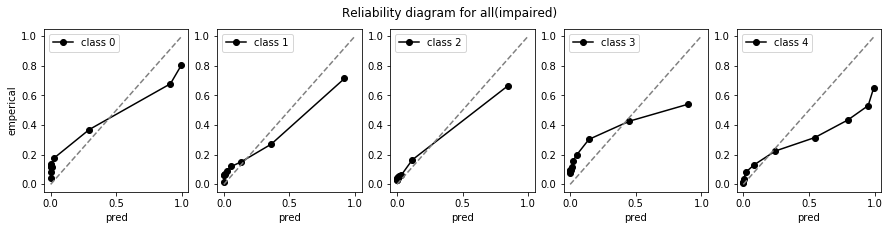

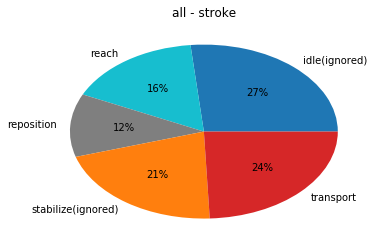

(7882815,)
0.13282405353416618
0.09249630776252422


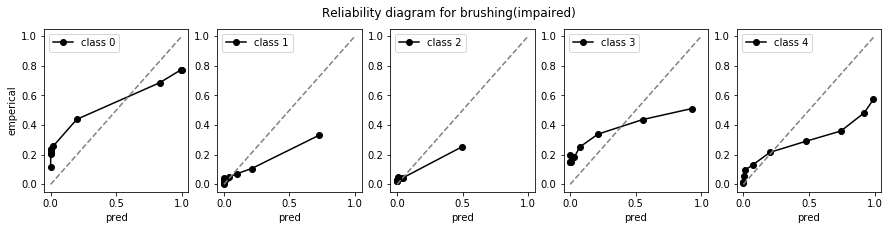

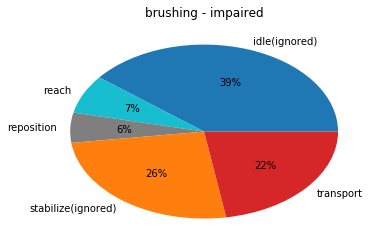

(1929090,)
0.06849671631544425
0.06395415074764015


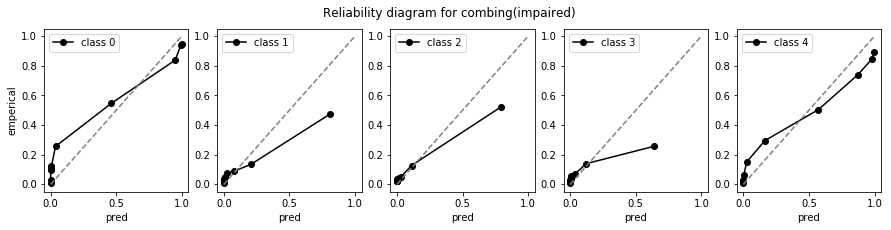

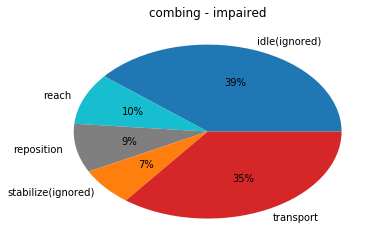

(3274695,)
0.12927298873723486
0.10701490873553508


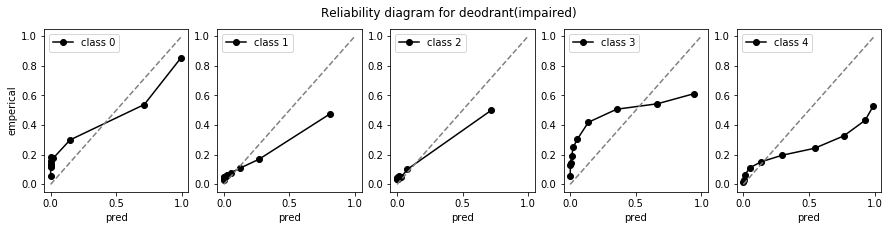

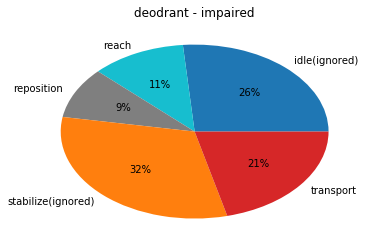

(3662710,)
0.10923675191956965
0.09548800785893534


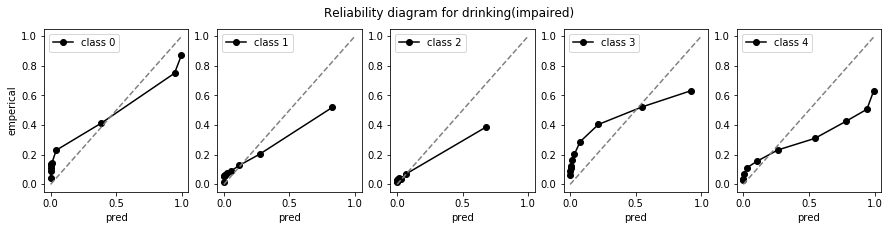

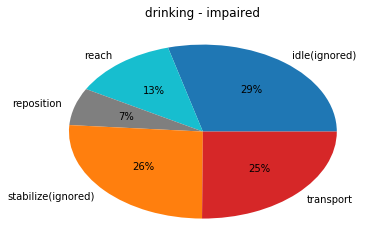

(5354190,)
0.11286619407045043
0.09694248756065178


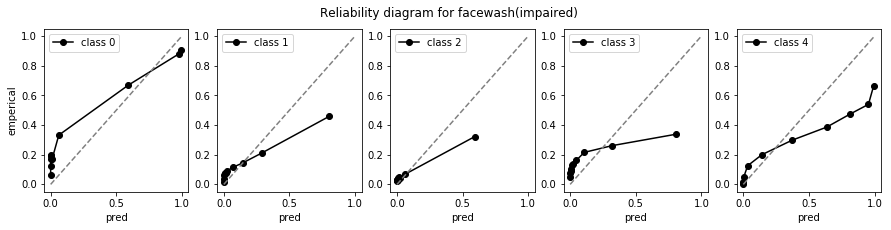

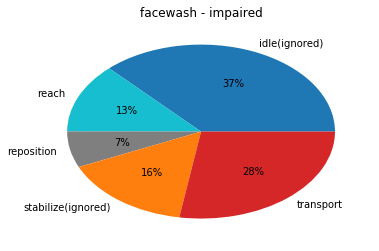

(11349430,)
0.13661925977699252
0.09820872509760324


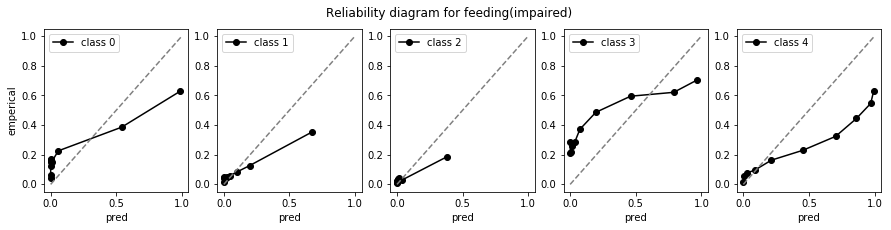

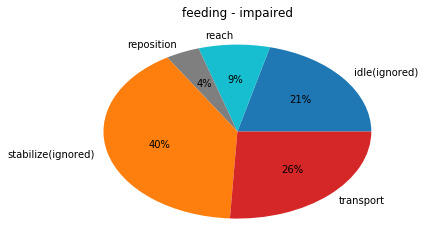

(2359455,)
0.10618882961250793
0.10269753441415876


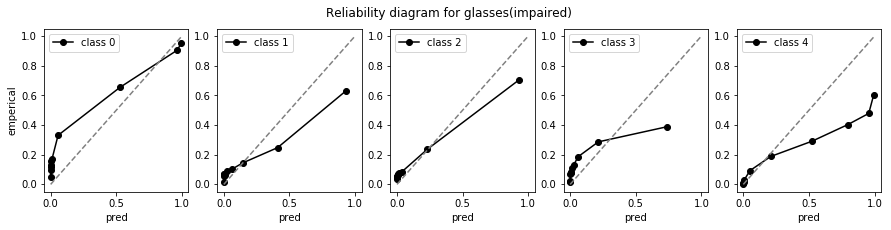

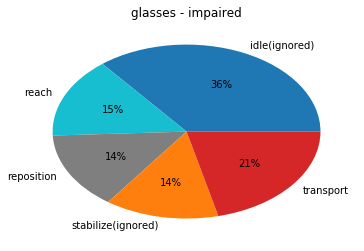

(5832540,)
0.07945597730535496
0.0968777407076812


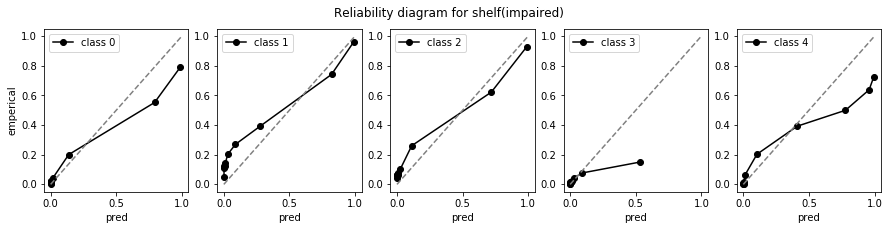

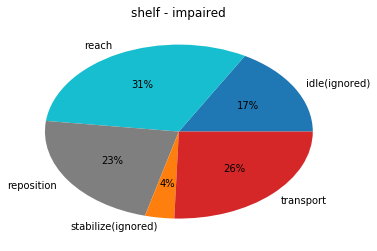

(7770595,)
0.08969202328761088
0.1039233597921702


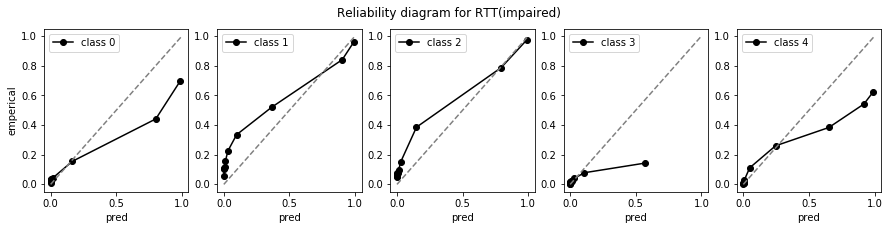

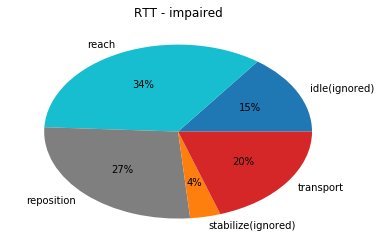

In [6]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']

for activity in activities:
#activity='shelf'
    df = None
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model._stroke.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []

            balanced_acc = []
            f1_score = []
            recall_score = []
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                #data_dict['activity'].append(split_name[1])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='keep',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
        #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
        #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
        #         data_dict['probs'][j] = probs
        #     probs_cal.append(data_dict['probs_cal'])
                unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
                freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
                sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
                balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),))
                f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                    data_dict['probs'][j].argmax(axis=0),
                                                   average = 'macro'
                                                          )
                                    )
                recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                           data_dict['probs'][j].argmax(axis=0),
                                                           average='macro'
                                                          )
                                    )

            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],
                                 'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],
                                 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score
                                })
        #     temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal']})
        #     temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob'] = temp.prob.map(collate_confidence)
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)

    met = df[['balanced_acc','recall_score','f1_score']].mean()
    print(met)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    df = pd.merge(df,fm_score[['sub','FM Score','Severity']],on='sub')    

    labels = np.concatenate(df['gt'].values)
    probs = np.concatenate(df['prob'].values, axis=1)
    # probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)

    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    
    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(impaired)')
    # plt.tight_layout()

    plt.show()
    
    """
    0 idle
    1 reach
    2 reposition
    3 stabilize
    4 transport
    """

    unique, counts = np.unique(labels, return_counts=True)
    

    x = counts#[15, 25, 25, 30, 5]
    class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
    colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

    fig, ax = plt.subplots()
    ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
    ax.set_title(activity  + ' - stroke')
    plt.show()
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(impaired)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - impaired')
        plt.show()


all
(6249415,)
0.045622522316038534
0.04590305445811646


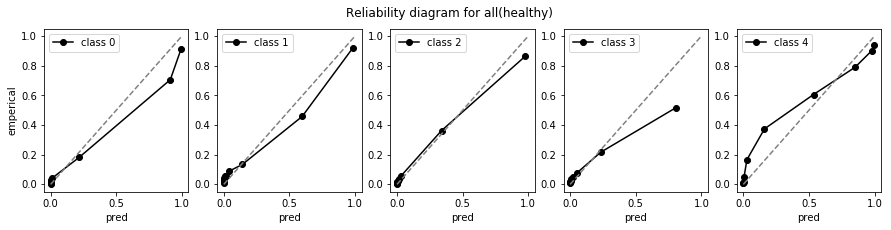

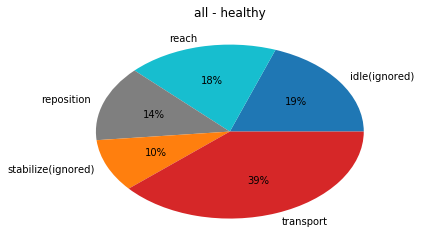

(881030,)
0.076272452888461
0.07150023415491182


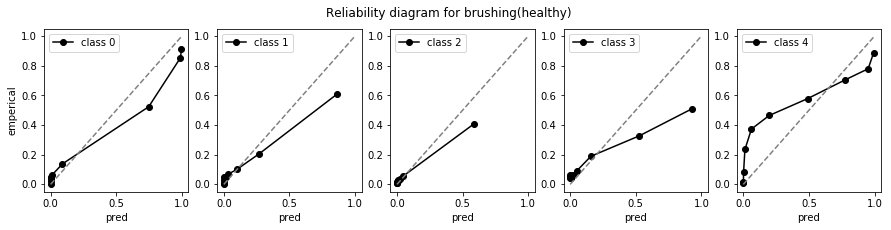

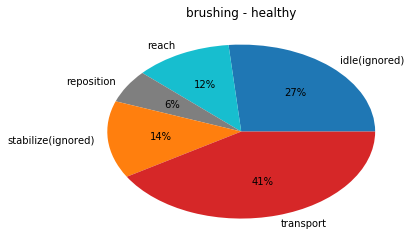

(255195,)
0.021551856082142974
0.023417414366071837


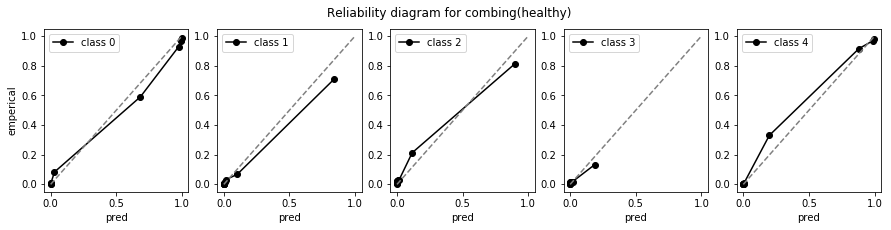

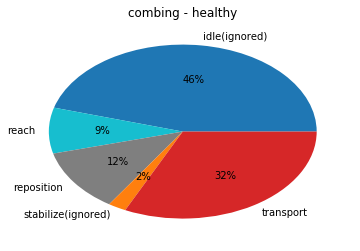

(390400,)
0.06454690856826498
0.06593150370825006


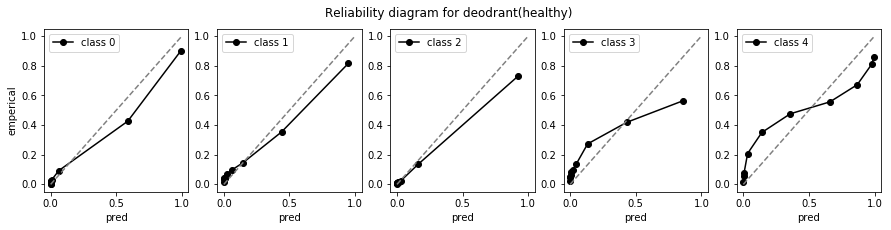

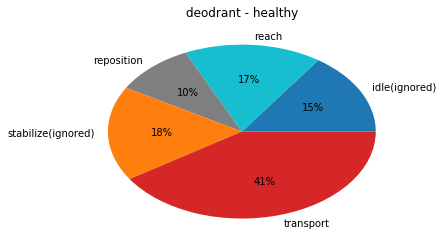

(423850,)
0.04917557910834939
0.053757417756448635


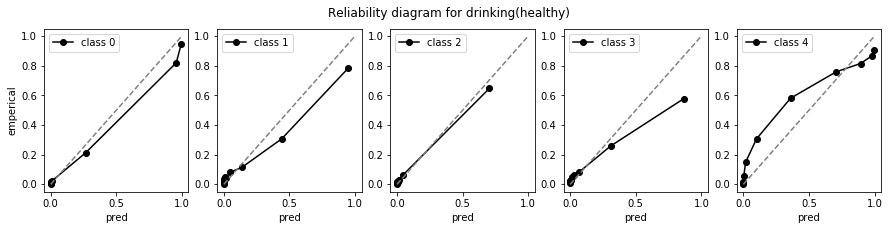

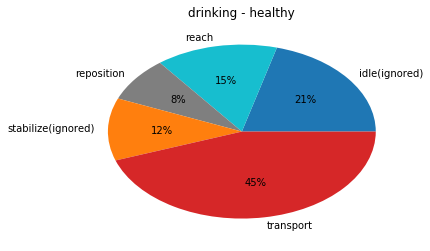

(707800,)
0.0820154176366675
0.0752256889273833


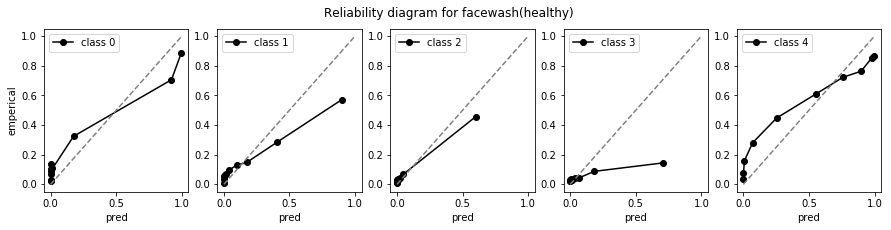

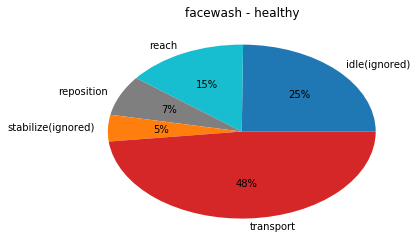

(1078975,)
0.05386807894226382
0.05555161276634114


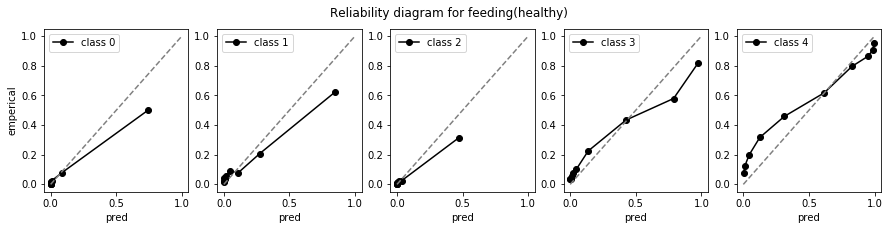

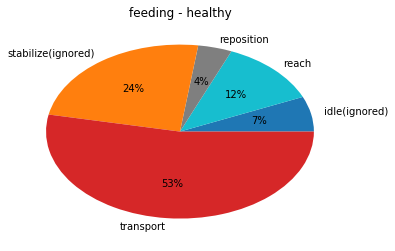

(250540,)
0.034311614015909195
0.042089966863362915


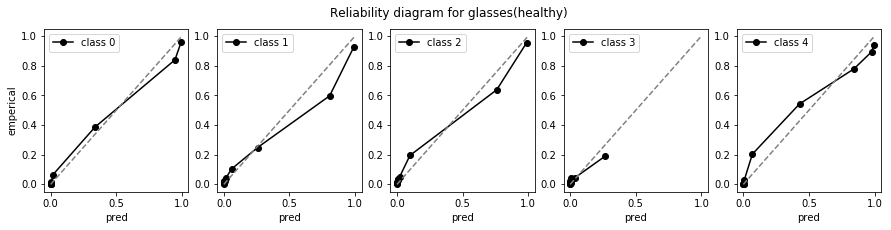

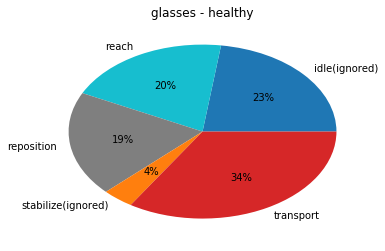

(1090575,)
0.02927727323329592
0.024761154914827065


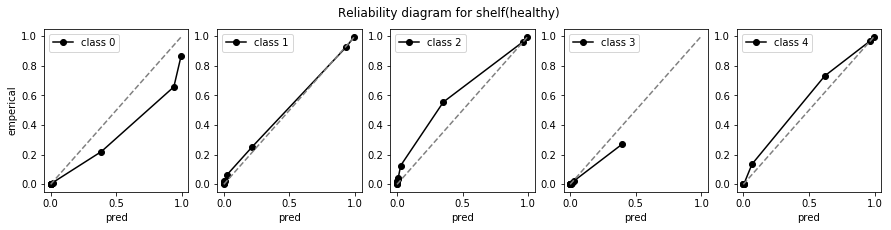

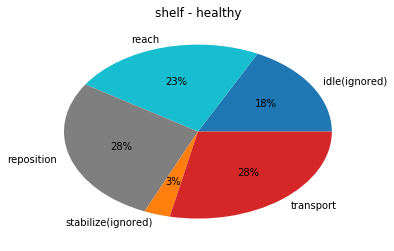

(1171050,)
0.034595198439259914
0.040047265039996734


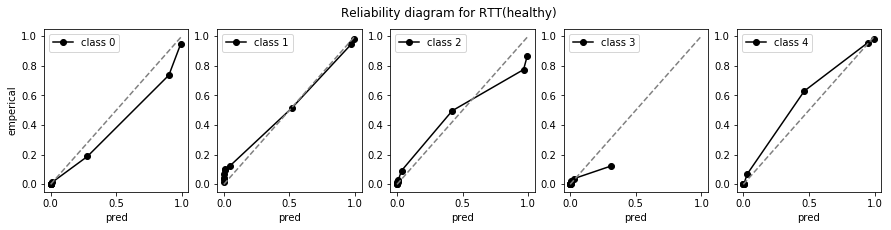

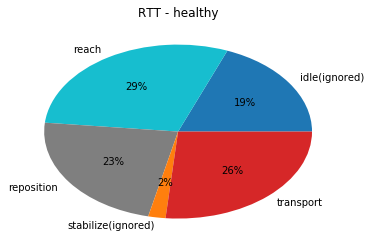

In [18]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']

for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []


        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            if val_len<1.:
                print('h')
                probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='keep',return_idx=True)
                data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                data_dict['probs'][j] = probs
                data_dict['gt'][j] = data_dict['gt'][j].numpy()[indices]

            else:
                data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
    #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
    #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
    #         data_dict['probs'][j] = probs
    #     probs_cal.append(data_dict['probs_cal'])

        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
    #     temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal']})
    #     temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
        temp['seq_prob'] = temp.prob.map(collate_confidence)
        #print(temp.shape)
        if df is None:
            df=temp
        else:
            df = pd.concat([df,temp],ignore_index=True)

    labels = np.concatenate(df['gt'].values)
    probs = np.concatenate(df['prob'].values, axis=1)
    # probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)
    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    

    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(healthy)')
    # plt.tight_layout()

    """
    0 idle
    1 reach
    2 reposition
    3 stabilize
    4 transport
    """
    
    unique, counts = np.unique(labels, return_counts=True)

    x = counts#[15, 25, 25, 30, 5]
    class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
    colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

    fig, ax = plt.subplots()
    ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
    ax.set_title(activity + ' - healthy')
    plt.show()
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(healthy)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - healthy')
        plt.show()
    

# early stop model - loss

all


/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


balanced_acc    0.557245
recall_score    0.548400
f1_score        0.507495
dtype: float64
(49415520,)
0.07601298616508238
0.05306667863475963


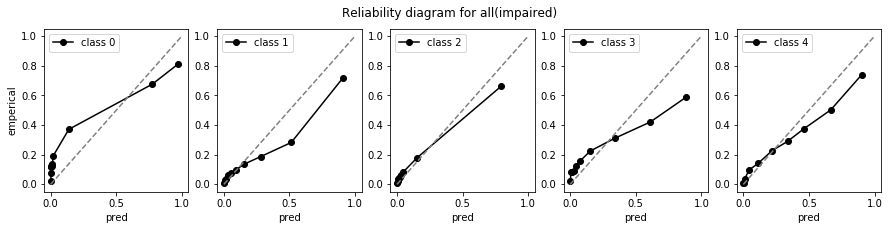

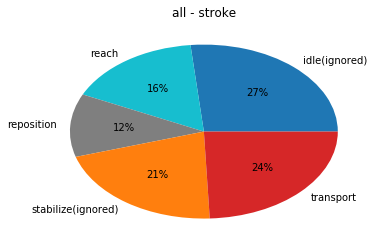

(7882815,)
0.10901677829118203
0.06975086959822206


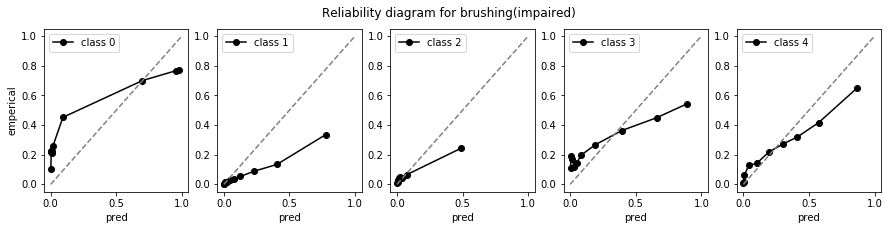

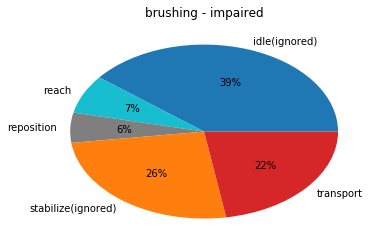

(1929090,)
0.0633138824990617
0.05862348015022384


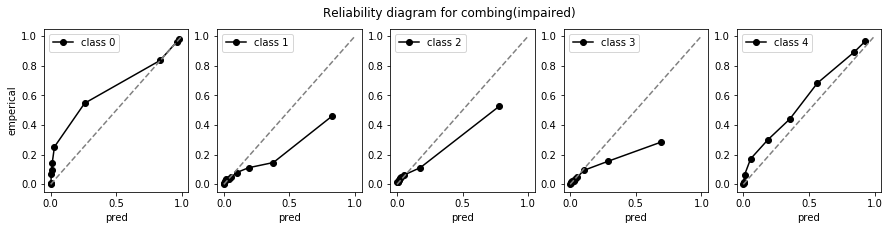

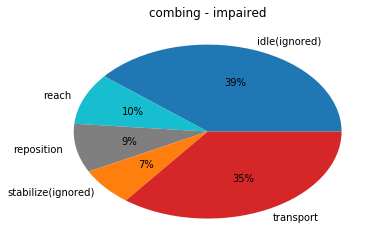

(3274695,)
0.09003567099733636
0.06726106965043564


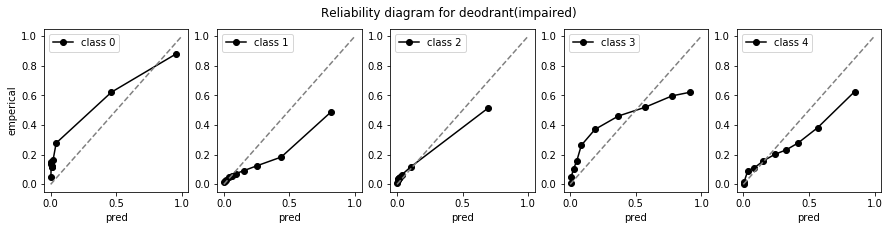

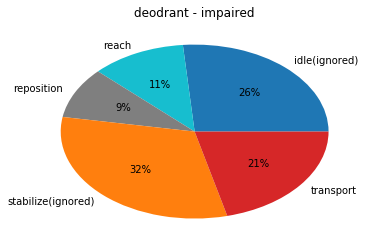

(3662710,)
0.07542622007467606
0.05607123734349186


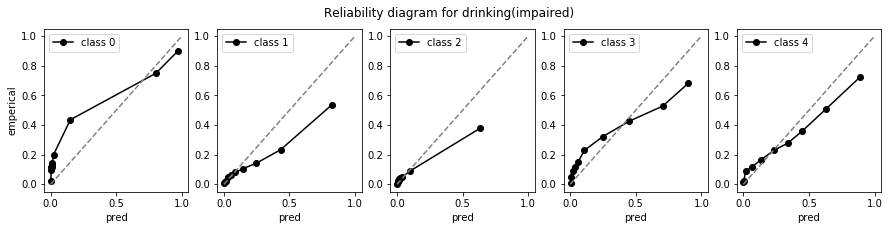

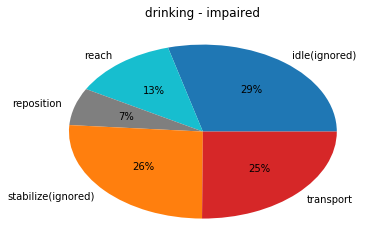

(5354190,)
0.09004443122885754
0.059992042420828916


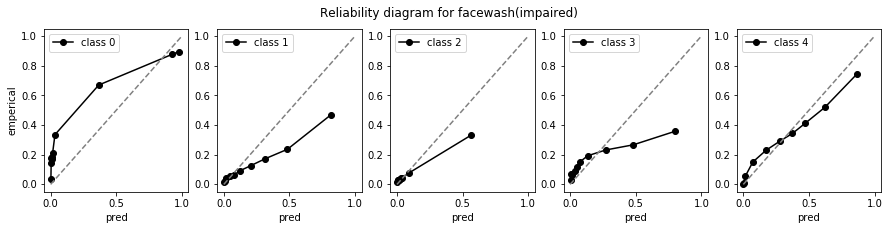

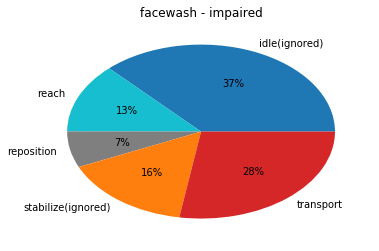

(11349430,)
0.1020972920392372
0.06341421232892845


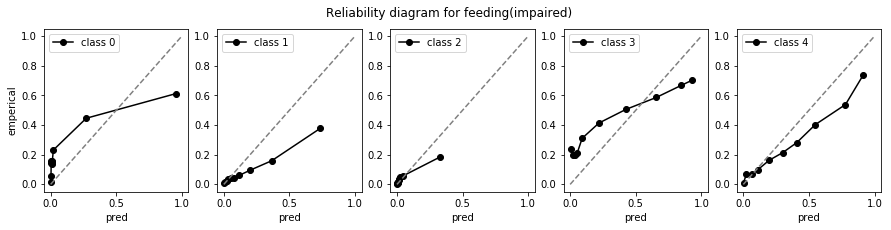

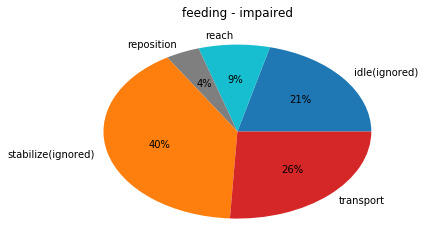

(2359455,)
0.08081587476780949
0.06729166756442502


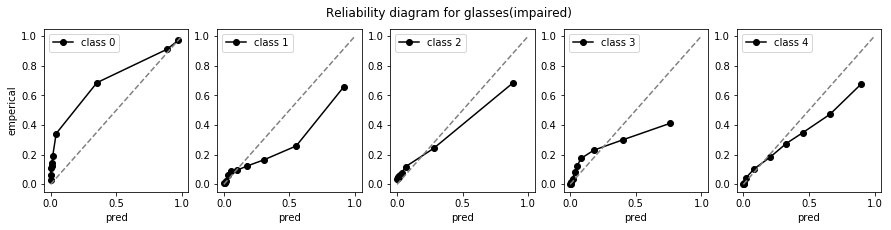

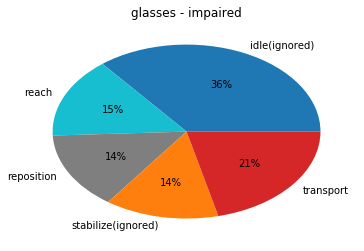

(5832540,)
0.06177728415779406
0.06395538240112529


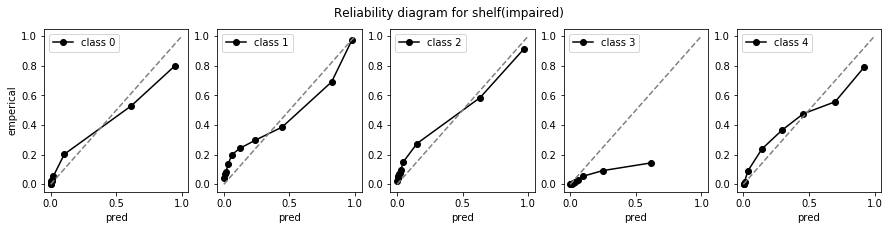

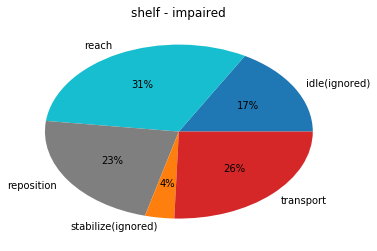

(7770595,)
0.06734500195616086
0.06328097822020702


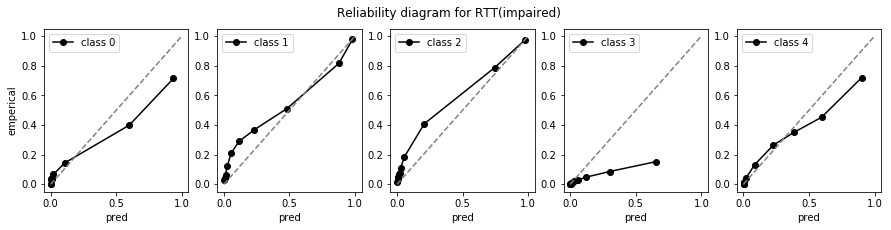

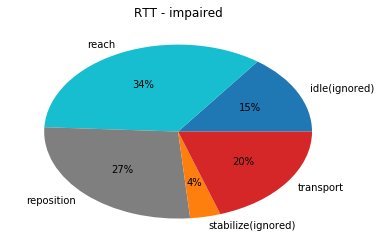

In [22]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']

for activity in activities:
#activity='shelf'
    df = None
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model._stroke.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []

            balanced_acc = []
            f1_score = []
            recall_score = []
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                #data_dict['activity'].append(split_name[1])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='keep',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
        #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
        #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
        #         data_dict['probs'][j] = probs
        #     probs_cal.append(data_dict['probs_cal'])
                unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
                freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
                sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
                balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),))
                f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                    data_dict['probs'][j].argmax(axis=0),
                                                   average = 'macro'
                                                          )
                                    )
                recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                           data_dict['probs'][j].argmax(axis=0),
                                                           average='macro'
                                                          )
                                    )

            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],
                                 'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],
                                 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score
                                })
        #     temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal']})
        #     temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob'] = temp.prob.map(collate_confidence)
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)

    met = df[['balanced_acc','recall_score','f1_score']].mean()
    print(met)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    df = pd.merge(df,fm_score[['sub','FM Score','Severity']],on='sub')    

    labels = np.concatenate(df['gt'].values)
    probs = np.concatenate(df['prob'].values, axis=1)
    # probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)

    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    
    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(impaired)')
    # plt.tight_layout()

    plt.show()
    
    """
    0 idle
    1 reach
    2 reposition
    3 stabilize
    4 transport
    """

    unique, counts = np.unique(labels, return_counts=True)
    

    x = counts#[15, 25, 25, 30, 5]
    class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
    colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

    fig, ax = plt.subplots()
    ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
    ax.set_title(activity  + ' - stroke')
    plt.show()
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(impaired)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - impaired')
        plt.show()


all
(6249415,)
0.053823617702494365
0.05896201492070189


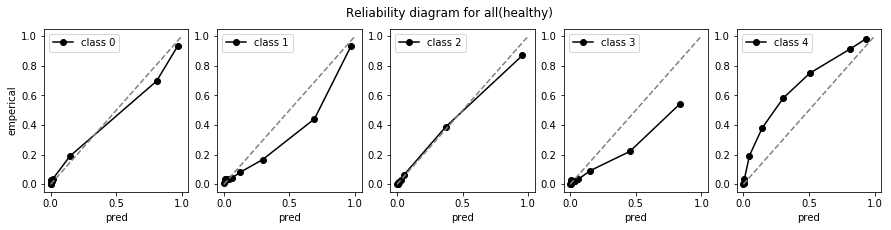

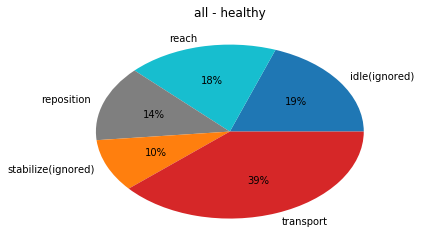

(881030,)
0.07921590284003469
0.08378062463236714


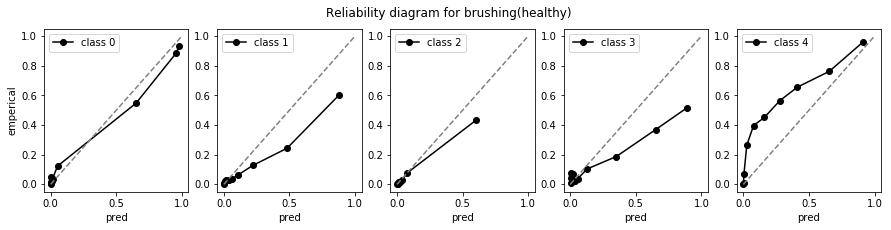

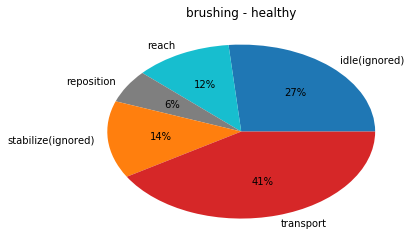

(255195,)
0.02644739048945944
0.03160299724242053


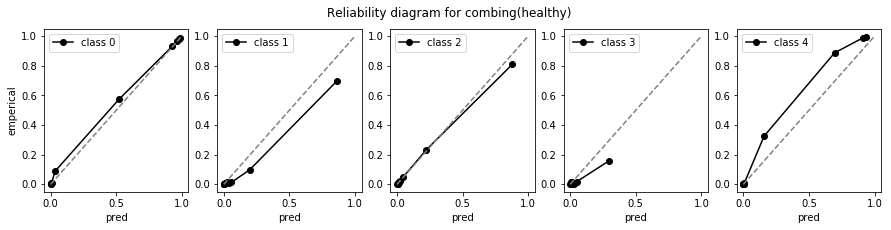

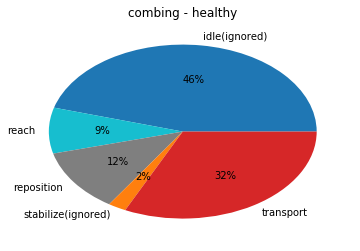

(390400,)
0.05643751204713312
0.07039212365941412


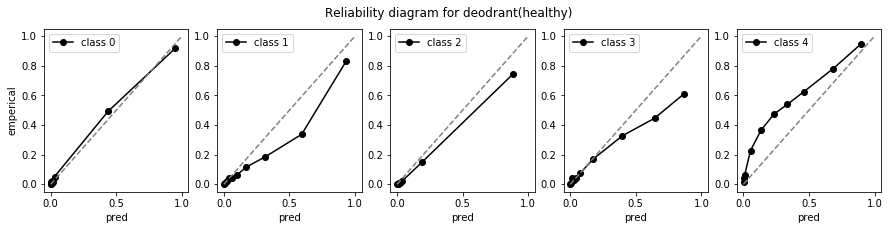

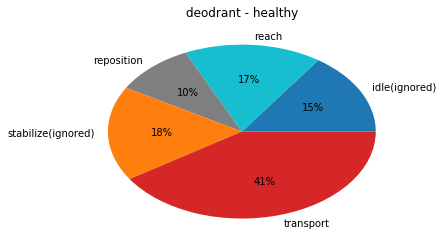

(423850,)
0.06705921420757524
0.07669638734246319


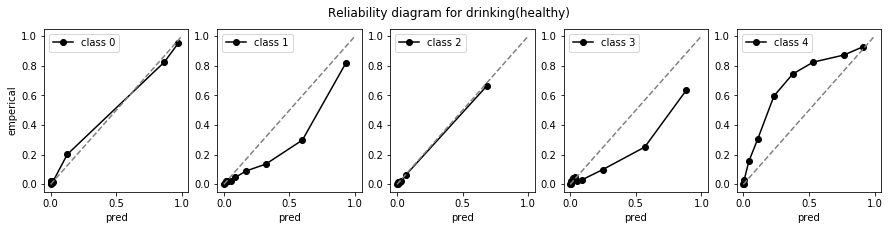

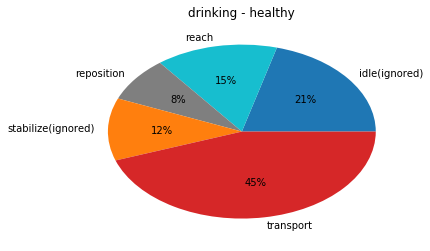

(707800,)
0.09622394608833615
0.09083682200526383


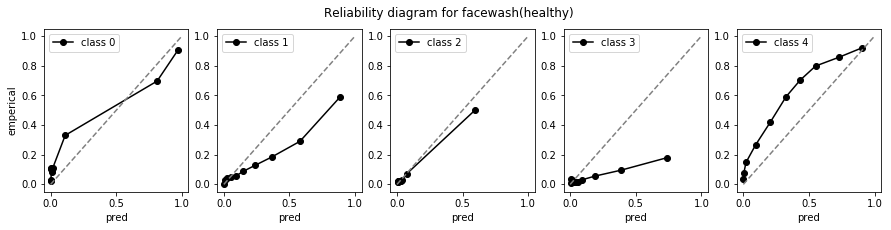

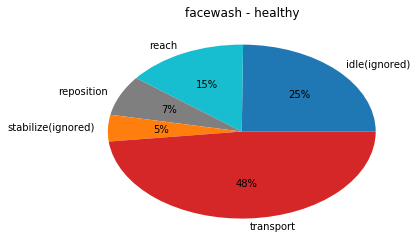

(1078975,)
0.06220243356549911
0.07484255933751106


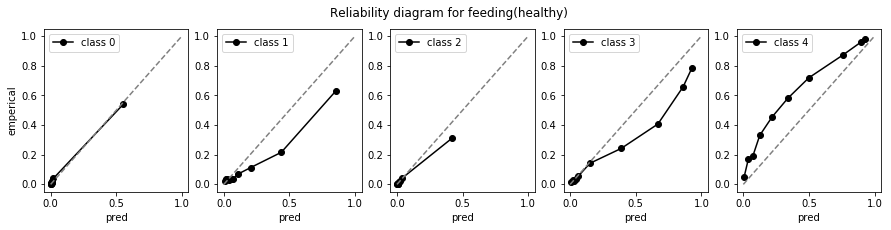

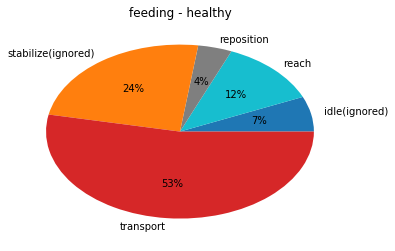

(250540,)
0.04537821286518408
0.057402707257375146


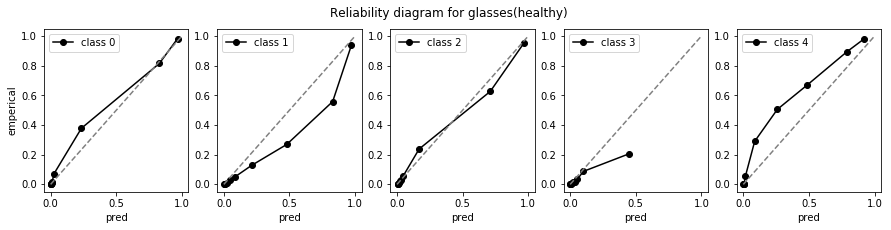

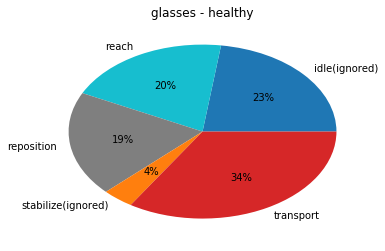

(1090575,)
0.038662360166598554
0.037455077318315655


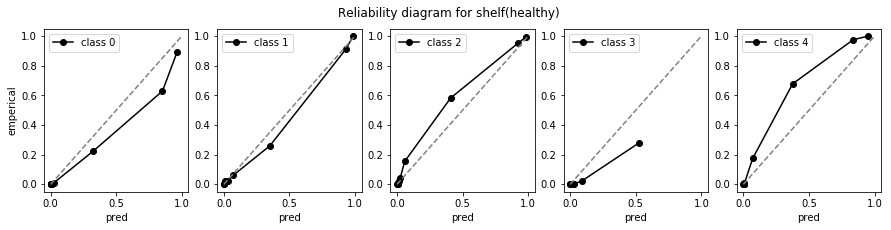

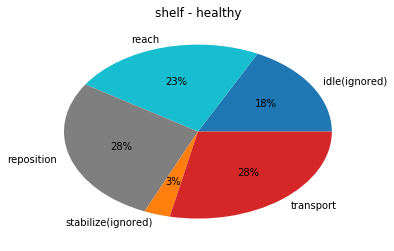

(1171050,)
0.04211732331624067
0.04874472565601717


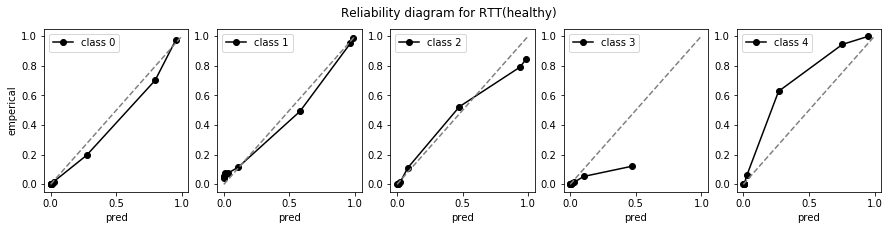

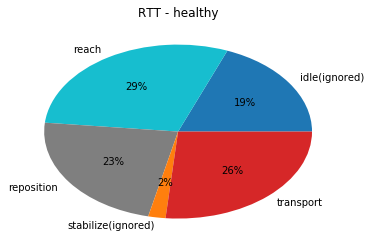

In [23]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']

for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []


        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            if val_len<1.:
                print('h')
                probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='keep',return_idx=True)
                data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                data_dict['probs'][j] = probs
                data_dict['gt'][j] = data_dict['gt'][j].numpy()[indices]

            else:
                data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
    #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
    #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
    #         data_dict['probs'][j] = probs
    #     probs_cal.append(data_dict['probs_cal'])

        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
    #     temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal']})
    #     temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
        temp['seq_prob'] = temp.prob.map(collate_confidence)
        #print(temp.shape)
        if df is None:
            df=temp
        else:
            df = pd.concat([df,temp],ignore_index=True)

    labels = np.concatenate(df['gt'].values)
    probs = np.concatenate(df['prob'].values, axis=1)
    # probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)
    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    

    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(healthy)')
    # plt.tight_layout()

    """
    0 idle
    1 reach
    2 reposition
    3 stabilize
    4 transport
    """
    
    unique, counts = np.unique(labels, return_counts=True)

    x = counts#[15, 25, 25, 30, 5]
    class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
    colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

    fig, ax = plt.subplots()
    ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
    ax.set_title(activity + ' - healthy')
    plt.show()
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(healthy)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - healthy')
        plt.show()
    

# post processing calibration

## Dirichlet calibration

In [4]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']

for activity in activities:
#activity='shelf'
    df = None
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model_stroke_dirichlet_cal.p')
#                 data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model._stroke.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []


            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='keep',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
        #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
        #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
        #         data_dict['probs'][j] = probs
            probs_cal.append(data_dict['probs_cal'])


            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],
                                 'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal'],
                                })
        #     temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal']})
        #     temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob'] = temp.prob.map(collate_confidence)
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)

    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    df = pd.merge(df,fm_score[['sub','FM Score','Severity']],on='sub')    

    labels = np.concatenate(df['gt'].values)
#     probs = np.concatenate(df['prob'].values, axis=1)
    probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)
    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    

    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(impaired)')
    # plt.tight_layout()

    plt.show()
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(impaired)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - impaired')
        plt.show()



all
name 'acts' is not defined
name 'acts' is not defined
name 'acts' is not defined
name 'acts' is not defined
name 'acts' is not defined


TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

all
(5572391,)
0.012852127474156172
0.014705661097559622


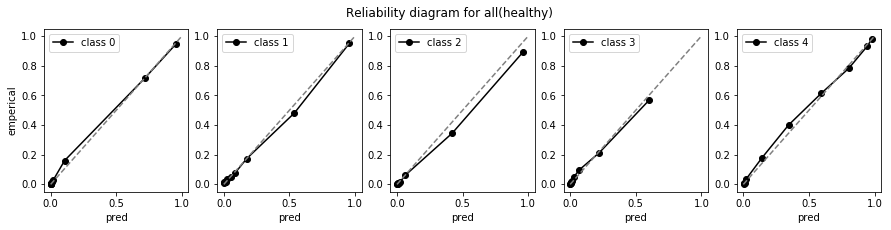

In [18]:
corr_dict = {}
confidence_score = {}
subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all',]

for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        s=subject[i-1]
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model_dirichlet_cal.p')
    #             data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []

            
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs_cal'][j].T,val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs_cal'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]
                    #print(probs.shape, labels.shape)
                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
        #         probs, labels = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=0.5,method='keep')
        #         data_dict['r_pred'][j] = ''.join(labels.astype('str'))
        #         data_dict['probs'][j] = probs

            probs_cal.append(data_dict['probs_cal'])

    #         temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],
                                 'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs'],'probs_cal':data_dict['probs_cal'],
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
#             temp['seq_prob'] = temp.prob.map(collate_confidence)
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)

    labels = np.concatenate(df['gt'].values)
#     probs = np.concatenate(df['prob'].values, axis=1)
    probs = np.concatenate(df['probs_cal'].values, axis=0)

    ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

    #print(binned_probs_true, binned_probs_pred)
    print(sum(ECE_.values()) / len(ECE_))
    print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)
    

    k=5
    fig, axes = plt.subplots(1,k,figsize=(k*3,3))

    for i in range(k):
        axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
        axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
        axes[i].legend()
        axes[i].set_xlabel('pred')
        if i==0:
            axes[i].set_ylabel('emperical')
    plt.suptitle(f'Reliability diagram for {activity}(healthy)')
    # plt.tight_layout()

    """
    0 idle
    1 reach
    2 reposition
    3 stabilize
    4 transport
    """
    
    for a in acts:
        labels = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a]['prob'].values, axis=1)
        # probs = np.concatenate(df['probs_cal'].values, axis=0)

        ECE_, binned_probs_true, binned_probs_pred= ECE(labels,probs,num_classes=5, n_bins=10, strategy= "uniform",mode='classwise')

        #print(binned_probs_true, binned_probs_pred)
        print(sum(ECE_.values()) / len(ECE_))
        print((ECE_[1]+ECE_[2]+ECE_[4]) / 3)


        k=5
        fig, axes = plt.subplots(1,k,figsize=(k*3,3))

        for i in range(k):
            axes[i].plot(binned_probs_pred[i], binned_probs_true[i],'o-',color='black',label=f'class {i}')
            axes[i].plot([0,1],[0,1],color='gray', linestyle='dashed')
            axes[i].legend()
            axes[i].set_xlabel('pred')
            if i==0:
                axes[i].set_ylabel('emperical')
        plt.suptitle(f'Reliability diagram for {a}(healthy)')
        # plt.tight_layout()

        """
        0 idle
        1 reach
        2 reposition
        3 stabilize
        4 transport
        """

        unique, counts = np.unique(labels, return_counts=True)

        x = counts#[15, 25, 25, 30, 5]
        class_names = ['idle(ignored)', 'reach', 'reposition', 'stabilize(ignored)', 'transport']
        colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red']

        fig, ax = plt.subplots()
        ax.pie(x, labels = class_names, colors = colors, autopct='%.0f%%')
        ax.set_title(a + ' - healthy')
        plt.show()
      
    

# load healthy prediction and assess balanced acc - best cer

In [25]:
corr_dict = {}
confidence_score = {}
# subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
#            "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
#            "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']

for activity in activities:
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}'))
    prob = []
    for i in range(1,n_splits+1):
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []
        
        acc = []
        balanced_acc = []
        f1_score = []
        recall_score = []

        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                
            unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
            freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
            sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
            #print(unique, counts,freq_count)  
#             balanced_acc.append(metrics.accuracy_score(data_dict['gt'][j], 
#                                                        data_dict['probs'][j].argmax(axis=0),
#                                                        sample_weight = sample_weight
#                                                       )
#                                 )
            acc.append(metrics.accuracy_score(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                data_dict['probs'][j].argmax(axis=0),
                                               average = 'macro'
                                                      )
                                )
            recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),
                                                       average='macro'
                                                      )
                                )
            
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],
                             'rep':data_dict['rep'],'gt':data_dict['gt'], 'probs':data_dict['probs'],
                             'acc':acc, 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score})
        if df is None:
            df = temp
        else:
            df = pd.concat([df,temp],ignore_index=True)
    gt = np.concatenate(df['gt'].values)
    probs = np.concatenate(df.probs.map(lambda x: x.argmax(axis=0)).values)
    print('f1 score', metrics.f1_score(gt,probs,average='macro'))
    print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
    a = metrics.confusion_matrix(gt,probs)
    print('confusion matrix \n', a)
    print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
    print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
    print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
    print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    
    for a in acts:
        print('\n')
        print(a)
        gt = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a].probs.map(lambda x: x.argmax(axis=0)).values)
        print('f1 score', metrics.f1_score(gt,probs,average='macro'))
        print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
        a = metrics.confusion_matrix(gt,probs)
        print('confusion matrix \n', a)
        print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
        print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
        print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    


all


/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score 0.7335111111314208
recall_score score 0.7370677845645951
confusion matrix 
 [[1045863   29022   44994   61766   34455]
 [  64944  801823   64230   38861  164382]
 [ 140178   25422  659436   14644   33565]
 [  60098   27476   11943  344694  168239]
 [  35485  160700   49884  235564 1931747]]
motion class acc 0.7674982158468987
motion class acc 0.7541710952049593
motion class precision 0.8064534223464924
motion class precision 0.7966554542614119
brushing
f1 score 0.6232126411070086
recall_score score 0.628736234773197
confusion matrix 
 [[199711   2026   4493  16029  11326]
 [  4552  56405   5503   4472  32263]
 [ 13256   3564  28915   1773   6382]
 [ 23938   2999   1729  67598  30156]
 [  9646  33520  12272  64354 244148]]
motion class acc 0.6323458567247253
motion class acc 0.5846631165375248
motion class precision 0.692594718110746
motion class precision 0.6239785918993116
combing
f1 score 0.745448929013498
recall_score score 0.7343681099100622
confusion matrix 
 [[111319    

# load stroke prediction and assess balanced acc - best cer

In [26]:
corr_dict = {}
confidence_score = {}
# subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
#            "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
#            "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']

for activity in activities:
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}'))
    prob = []
    for i in range(1,n_splits+1):
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model._stroke.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []
        
        acc = []
        balanced_acc = []
        f1_score = []
        recall_score = []
        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                
            unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
            freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
            sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
            #print(unique, counts,freq_count)  
#             balanced_acc.append(metrics.accuracy_score(data_dict['gt'][j], 
#                                                        data_dict['probs'][j].argmax(axis=0),
#                                                        sample_weight = sample_weight
#                                                       )
#                                 )
            acc.append(metrics.accuracy_score(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                data_dict['probs'][j].argmax(axis=0),
                                               average = 'macro'
                                                      )
                                )
            recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),
                                                       average='macro'
                                                      )
                                )
            
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],
                             'rep':data_dict['rep'],'gt':data_dict['gt'],'probs':data_dict['probs'],
                             'acc':acc, 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score})
        if df is None:
            df = temp
        else:
            df = pd.concat([df,temp],ignore_index=True)
    gt = np.concatenate(df['gt'].values)
    probs = np.concatenate(df.probs.map(lambda x: x.argmax(axis=0)).values)
    print('f1 score', metrics.f1_score(gt,probs,average='macro'))
    print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
    a = metrics.confusion_matrix(gt,probs)
    print('confusion matrix \n', a)
    print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
    print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
    print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
    print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    
    for a in acts:
        print('\n')
        print(a)
        gt = np.concatenate(df[df['act']==a]['gt'].values)
        probs = np.concatenate(df[df['act']==a].probs.map(lambda x: x.argmax(axis=0)).values)
        print('f1 score', metrics.f1_score(gt,probs,average='macro'))
        print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
        a = metrics.confusion_matrix(gt,probs)
        print('confusion matrix \n', a)
        print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
        print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
        print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)


all


/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/cpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score 0.5661647895057014
recall_score score 0.5592298288265352
confusion matrix 
 [[8370756  529615  865229 2278335 1762350]
 [ 805489 4256353  263847  464845 2832981]
 [ 842141  444983 3390198  282541 1332032]
 [1620183  517108  170569 4102414 4357096]
 [ 300076 1068007  314691 1107981 9693020]]
motion class acc 0.6328498822136498
motion class acc 0.6029481592425285
motion class precision 0.5453024693724423
motion class precision 0.595693851986841


brushing
f1 score 0.4667834089247059
recall_score score 0.4818251925890471
confusion matrix 
 [[1880977  104007  153479  563867  531405]
 [  36687  247439   22266   32832  246601]
 [  52077   55801  157987   24944  173966]
 [ 526616   90145   31899  717468  718857]
 [  60280  209174   47351  183271 1292584]]
motion class acc 0.5972053206530532
motion class acc 0.49444697676276733
motion class precision 0.41587710487560375
motion class precision 0.3896440155662592


combing
f1 score 0.5822819191668832
recall_score score 0.583908786727639

# load healthy prediction and assess balanced acc - best loss

In [5]:
corr_dict = {}
confidence_score = {}
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']

# subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
#            "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
#            "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']
healthy_performance_dict= {} #motion corr, motion/overall precision recall, available record
for activity in activities:
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}'))
    prob = []
    for i in range(1,n_splits+1):
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []
        
        acc = []
        balanced_acc = []
        f1_score = []
        recall_score = []

        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                
            unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
            freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
            sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
            #print(unique, counts,freq_count)  
#             balanced_acc.append(metrics.accuracy_score(data_dict['gt'][j], 
#                                                        data_dict['probs'][j].argmax(axis=0),
#                                                        sample_weight = sample_weight
#                                                       )
#                                 )
            acc.append(metrics.accuracy_score(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                data_dict['probs'][j].argmax(axis=0),
                                               average = 'macro'
                                                      )
                                )
            recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),
                                                       average='macro'
                                                      )
                                )
            
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],
                             'rep':data_dict['rep'],'gt':data_dict['gt'], 'probs':data_dict['probs'],
                             'acc':acc, 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score})
        if df is None:
            df = temp
        else:
            df = pd.concat([df,temp],ignore_index=True)
    gt = np.concatenate(df['gt'].values)
    probs = np.concatenate(df.probs.map(lambda x: x.argmax(axis=0)).values)
    print('f1 score', metrics.f1_score(gt,probs,average='macro'))
    print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
    a = metrics.confusion_matrix(gt,probs)
    print('confusion matrix \n', a)
    print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
    print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
    print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
    print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    
    for act in acts:
        print(act)
        gt = np.concatenate(df[df['act']==act]['gt'].values)
        probs = np.concatenate(df[df['act']==act].probs.map(lambda x: x.argmax(axis=0)).values)
        print('f1 score', metrics.f1_score(gt,probs,average='macro'))
        print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
        a = metrics.confusion_matrix(gt,probs)
        healthy_performance_dict[act] = {}
        healthy_performance_dict[act]['n_unique_records'] = df[df['act']==act].shape[0]
        healthy_performance_dict[act]['n_unique_subjects'] = df[df.act==act]['sub'].unique().shape[0]
        
        healthy_performance_dict[act]['motion class acc'] = (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3
        healthy_performance_dict[act]['motion class precision'] = (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3
        healthy_performance_dict[act]['overall acc'] = metrics.recall_score(gt,probs,average='macro')
        healthy_performance_dict[act]['overall precision'] = (a[0][0]/a[:,0].sum()+a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[3][3]/a[:,3].sum()+a[4][4]/a[:,4].sum())/5
        
        print('confusion matrix \n', a)
        print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
        print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
        print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    
        

all


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score 0.7257580986792764
recall_score score 0.7546324724298162
confusion matrix 
 [[1027674   29151   59035   83416   16824]
 [  59672  869485   60816   55216   89051]
 [ 118593   34037  675015   22758   22842]
 [  40358   35284   10629  442911   83268]
 [  20489  329339   45011  412797 1605744]]
motion class acc 0.712585432941291
motion class acc 0.7349753924067929
motion class precision 0.7944066002762303
motion class precision 0.7824235759853181
brushing
f1 score 0.6207003812890239
recall_score score 0.6614654402078836
confusion matrix 
 [[201837   2736   6395  16419   6198]
 [  3488  69289   5101   6971  18346]
 [ 11060   5019  31939   1815   4057]
 [ 21635   4573   1736  85972  12504]
 [  5936  67878  11797  96692 181637]]
motion class acc 0.5429010124274267
motion class acc 0.587730945961518
motion class precision 0.6590440465511819
motion class precision 0.6131980991165632
combing
f1 score 0.7464952333862181
recall_score score 0.7631901115252111
confusion matrix 
 [[109445   

In [6]:
healthy_performance_dict

{'RTT': {'motion class acc': 0.8066708731352948,
  'motion class precision': 0.8737056370003747,
  'n_unique_records': 195,
  'n_unique_subjects': 4,
  'overall acc': 0.7463802494876038,
  'overall precision': 0.7160390439631645},
 'brushing': {'motion class acc': 0.587730945961518,
  'motion class precision': 0.6131980991165632,
  'n_unique_records': 160,
  'n_unique_subjects': 4,
  'overall acc': 0.6614654402078836,
  'overall precision': 0.6161063429783569},
 'combing': {'motion class acc': 0.8154995479128556,
  'motion class precision': 0.8041178122105999,
  'n_unique_records': 155,
  'n_unique_subjects': 4,
  'overall acc': 0.7631901115252111,
  'overall precision': 0.7354734913085264},
 'deodrant': {'motion class acc': 0.6922586185915446,
  'motion class precision': 0.6928997182665754,
  'n_unique_records': 160,
  'n_unique_subjects': 4,
  'overall acc': 0.7175440981923323,
  'overall precision': 0.68198796809038},
 'drinking': {'motion class acc': 0.695826360468425,
  'motion cl

In [7]:
def performance_bootstrap_ci(df, rep=100, n=9999, level = 0.95):
    gt = np.concatenate(df['gt'].values)
    probs = np.concatenate(df.probs.map(lambda x: x.argmax(axis=0)).values)
    motion_class_acc = []
    motion_class_precision = []
    overall_acc = []
    overall_precision = []
    for i in range(rep):
        id_sampled = np.random.choice(range(gt.shape[0]), n, replace = True)
        gt_sampled = gt[id_sampled]
        probs_sampled = probs[id_sampled]
        a = metrics.confusion_matrix(gt_sampled,probs_sampled)
        motion_class_acc.append((a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        motion_class_precision.append((a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
        overall_acc.append(metrics.recall_score(gt_sampled,probs_sampled,average='macro'))
        overall_precision.append((a[0][0]/a[:,0].sum()+a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[3][3]/a[:,3].sum()+a[4][4]/a[:,4].sum())/5)
    
#         print('confusion matrix \n', a)
#         print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
#         print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
#         print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
#         print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
#     print('motion class acc', np.mean(motion_class_acc), np.percentile(motion_class_acc, [5,95],))
#     print('motion class precision', np.mean(motion_class_precision))
        
    return {'motion class acc': (np.mean(motion_class_acc), np.percentile(motion_class_acc, [5,95],)),
            'motion class precision': (np.mean(motion_class_precision), np.percentile(motion_class_precision, [5,95],)),
            'overall acc': (np.mean(overall_acc), np.percentile(overall_acc, [5,95],)),
            'overall precision': (np.mean(overall_precision), np.percentile(overall_precision, [5,95],)),
           }

In [29]:
performance_bootstrap_ci(df)

{'motion class acc': (0.734454135502033, array([0.72647051, 0.74368376])),
 'motion class precision': (0.7817459980540368, array([0.7734483, 0.7908941])),
 'overall acc': (0.7547691103736013, array([0.74741325, 0.76119709])),
 'overall precision': (0.7185922965674988, array([0.7120993 , 0.72554552]))}

In [30]:
for act in acts:
    print(act)
    df_act = df[df['act']==act]
    print(performance_bootstrap_ci(df_act))

brushing
{'motion class acc': (0.587326985000626, array([0.57465016, 0.60211559])), 'motion class precision': (0.6120088609280228, array([0.59818032, 0.62532187])), 'overall acc': (0.661556867228258, array([0.65173564, 0.67179834])), 'overall precision': (0.615614209453181, array([0.60525913, 0.62443531]))}
combing
{'motion class acc': (0.8150071034886213, array([0.80341807, 0.82609781])), 'motion class precision': (0.804413261032701, array([0.79429513, 0.81576561])), 'overall acc': (0.7635681884523028, array([0.75038543, 0.77694423])), 'overall precision': (0.7356626703801398, array([0.72469871, 0.745501  ]))}
deodrant
{'motion class acc': (0.691541933768796, array([0.68053528, 0.7019037 ])), 'motion class precision': (0.6924999463887525, array([0.68171337, 0.70452855])), 'overall acc': (0.7173523769160163, array([0.70818822, 0.7260849 ])), 'overall precision': (0.6819916806218852, array([0.67435684, 0.69053433]))}
drinking
{'motion class acc': (0.6958333221799822, array([0.68585888, 

# load stroke prediction and assess balanced acc - best loss

In [8]:
corr_dict = {}
confidence_score = {}
# subject = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
#            "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
#            "C30", "C31", "C32"]
# subject = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
#                 "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
activities = ['all']
stroke_performance_dict = {}
for activity in activities:
    print(activity)
    n_splits = len(os.listdir(f'./result/sensors_{activity}'))
    prob = []
    for i in range(1,n_splits+1):
        data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model._stroke.p')
        data_dict['sub'] = []
        data_dict['activity'] = []
        data_dict['rep'] = []
        
        acc = []
        balanced_acc = []
        f1_score = []
        recall_score = []
        for j in range(len(data_dict['name'])):
            data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
            split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
            data_dict['sub'].append(split_name[0])
            for a in acts:
                if a=='deodrant':
                    if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                elif a=='facewash':
                    if 'face' in data_dict['name'][j]:
                        data_dict['activity'].append(a)
                else:
                    if a in data_dict['name'][j]:
                        data_dict['activity'].append(a)
            data_dict['rep'].append(data_dict['name'][j][-1])
            data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                
            unique, counts = np.unique(data_dict['gt'][j], return_counts=True)
            freq_count = {unique[i]:data_dict['gt'][j].shape[0]/counts[i] for i in range(unique.shape[0])} 
            sample_weight = np.array([freq_count[xi] for xi in data_dict['gt'][j]])
            #print(unique, counts,freq_count)  
#             balanced_acc.append(metrics.accuracy_score(data_dict['gt'][j], 
#                                                        data_dict['probs'][j].argmax(axis=0),
#                                                        sample_weight = sample_weight
#                                                       )
#                                 )
            acc.append(metrics.accuracy_score(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                   data_dict['probs'][j].argmax(axis=0),))
            f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                data_dict['probs'][j].argmax(axis=0),
                                               average = 'macro'
                                                      )
                                )
            recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),
                                                       average='macro'
                                                      )
                                )
            
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],
                             'rep':data_dict['rep'],'gt':data_dict['gt'],'probs':data_dict['probs'],
                             'acc':acc, 'balanced_acc':balanced_acc,'recall_score':recall_score, 'f1_score':f1_score})
        if df is None:
            df = temp
        else:
            df = pd.concat([df,temp],ignore_index=True)
    gt = np.concatenate(df['gt'].values)
    probs = np.concatenate(df.probs.map(lambda x: x.argmax(axis=0)).values)
    print('f1 score', metrics.f1_score(gt,probs,average='macro'))
    print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
    a = metrics.confusion_matrix(gt,probs)
    print('confusion matrix \n', a)
    print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
    print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
    print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
    print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)
    
    for act in acts:
        gt = np.concatenate(df[df['act']==act]['gt'].values)
        probs = np.concatenate(df[df['act']==act].probs.map(lambda x: x.argmax(axis=0)).values)
        print('f1 score', metrics.f1_score(gt,probs,average='macro'))
        print('recall_score score', metrics.recall_score(gt,probs,average='macro'))
        a = metrics.confusion_matrix(gt,probs)
        stroke_performance_dict[act] = {}
        stroke_performance_dict[act]['n_unique_records'] = df[df['act']==act].shape[0]
        stroke_performance_dict[act]['n_unique_subjects'] = df[df.act==act]['sub'].unique().shape[0]
        
        stroke_performance_dict[act]['motion class acc'] = (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3
        stroke_performance_dict[act]['motion class precision'] = (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3
        stroke_performance_dict[act]['overall acc'] = metrics.recall_score(gt,probs,average='macro')
        stroke_performance_dict[act]['overall precision'] = (a[0][0]/a[:,0].sum()+a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[3][3]/a[:,3].sum()+a[4][4]/a[:,4].sum())/5
        
        print('confusion matrix \n', a)
        print('motion class acc', (a[1][1]+a[2][2]+a[4][4])/(a[1].sum()+a[2].sum()+a[4].sum()))
        print('motion class acc', (a[1][1]/a[1].sum()+a[2][2]/a[2].sum()+a[4][4]/a[4].sum())/3)
        print('motion class precision', (a[1][1]+a[2][2]+a[4][4])/(a[:,1].sum()+a[:,2].sum()+a[:,4].sum()))
        print('motion class precision', (a[1][1]/a[:,1].sum()+a[2][2]/a[:,2].sum()+a[4][4]/a[:,4].sum())/3)


all


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


f1 score 0.5727485443377776
recall_score score 0.568062800192236
confusion matrix 
 [[7746137  754174  979167 3215892 1110915]
 [ 660355 4958414  232420  768719 2003607]
 [ 639758  793917 3370107  486600 1001513]
 [1263660  835620  143475 5666352 2858263]
 [ 191188 2161837  262311 1849002 8019437]]
motion class acc 0.5966585502451989
motion class acc 0.584334355088616
motion class precision 0.5544466631487408
motion class precision 0.5774288801696786
f1 score 0.46746061970154457
recall_score score 0.4939374269535607
confusion matrix 
 [[1792018  176346  174303  734035  357033]
 [  25259  325394   19603   56063  159506]
 [  41419  109121  157039   36023  121173]
 [ 476426  155269   34367  972277  446646]
 [  50416  418263   46176  281314  996491]]
motion class acc 0.5201508127993922
motion class acc 0.483066782225882
motion class precision 0.4000627581673533
motion class precision 0.37252303792737607
f1 score 0.5867868323222069
recall_score score 0.6123194908583063
confusion matrix 
 [[

In [9]:
stroke_performance_dict

{'RTT': {'motion class acc': 0.6441969906525812,
  'motion class precision': 0.7359061536866315,
  'n_unique_records': 1210,
  'n_unique_subjects': 50,
  'overall acc': 0.6180207616721922,
  'overall precision': 0.5945768358683561},
 'brushing': {'motion class acc': 0.483066782225882,
  'motion class precision': 0.37252303792737607,
  'n_unique_records': 1135,
  'n_unique_subjects': 50,
  'overall acc': 0.4939374269535607,
  'overall precision': 0.4672550976123574},
 'combing': {'motion class acc': 0.6205520419953136,
  'motion class precision': 0.5790826896591633,
  'n_unique_records': 1000,
  'n_unique_subjects': 51,
  'overall acc': 0.6123194908583063,
  'overall precision': 0.580088903153786},
 'deodrant': {'motion class acc': 0.5296274874201325,
  'motion class precision': 0.4762117499078684,
  'n_unique_records': 1090,
  'n_unique_subjects': 51,
  'overall acc': 0.5359709421197358,
  'overall precision': 0.5615595678296837},
 'drinking': {'motion class acc': 0.5455589407572644,
 

# generate distribution shift plot

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

corr_dict = {}
confidence_score = {}
subject_RTT = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
subject_other = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
                "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
#activities = ['brushing','combing', 'deodrant', 'drinking', 'facewash', 'feeding', 'glasses', 'shelf', 'RTT']
activities = ['all']
primatives = {0:'idle', 1: 'reach', 2: 'reposition', 3: 'stabilize', 4: 'transport'}
def remove_nan(x):
    x = np.array(x)
#     print(x.shape)
#     print(np.sum(np.isnan(x)))
    return x[~(np.isnan(x))]

for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        try:
            if activity=='RTT':
                data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_loss_model._stroke.p')
    #             data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_cer_model.p')

            else:
                data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model._stroke.p')
    #             data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                data_dict['activity'].append(split_name[1])
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() 
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

            probs_cal.append(data_dict['probs'])
            
    #         temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
            temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
            temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)
    prob = df.groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    fm_score = pd.read_csv('FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    
    severity_confi = final.groupby('Severity').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                                    'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                                    'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                                    'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                                    'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                                    'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                                    'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                                    'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                                    'prob_cal_4':lambda x: list(np.hstack(x.values))
                                                   })
    
    severity_confi.reset_index(drop=False,inplace=True)

    healthy_df = None
    for i in range(1,n_splits+1):       
        try:
            if activity=='RTT':
                data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_loss_model.p')
    #             data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_cer_model.p')
                s=subject_RTT[i-1]
            else:
                data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model.p')
    #             data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
                s=subject_other[i-1]
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []
            
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_')[0] #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                #print(data_dict['name'][j])
                data_dict['sub'].append(split_name)
                data_dict['activity'].append(split_name[1])
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs_cal'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy()
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])
                    
            probs_cal.append(data_dict['probs'])

    #         temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
            temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
            temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            
            #print(temp.shape)
            if healthy_df is None:
                healthy_df=temp
            else:
                healthy_df = pd.concat([healthy_df,temp],ignore_index=True)
        except Exception as e:
            print(e)
    
    healthy_prob = healthy_df.groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    healthy_prob.reset_index(drop=False,inplace=True)
    healthy_prob['Severity'] = 'healthy'
    final = pd.concat((final,healthy_prob))



all


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:187: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



generating individual plot
generating group plot
generating individual plot
generating group plot
generating individual plot
generating group plot


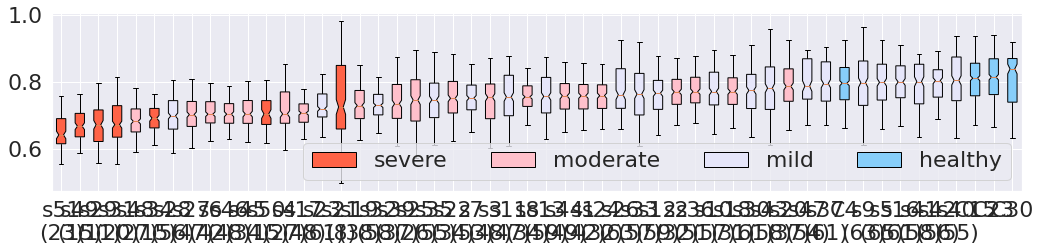

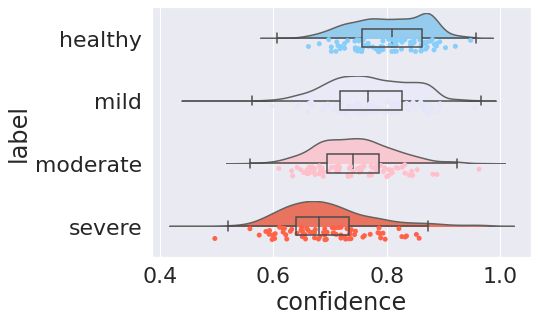

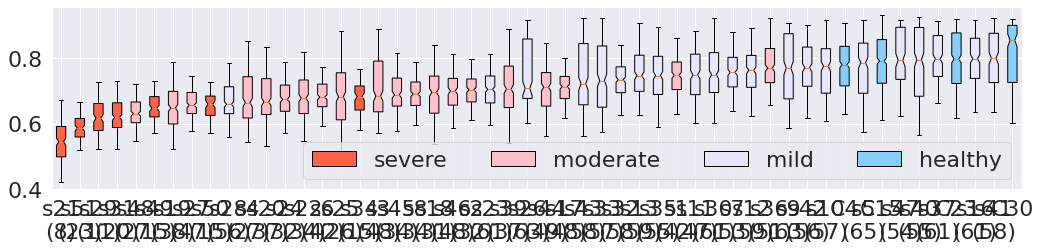

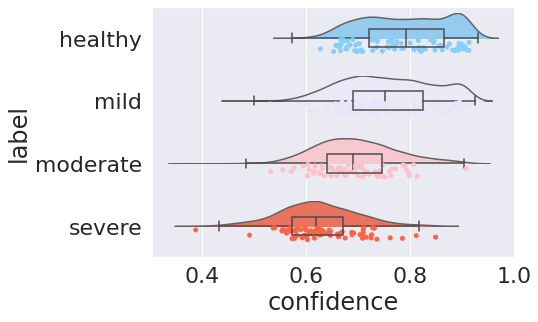

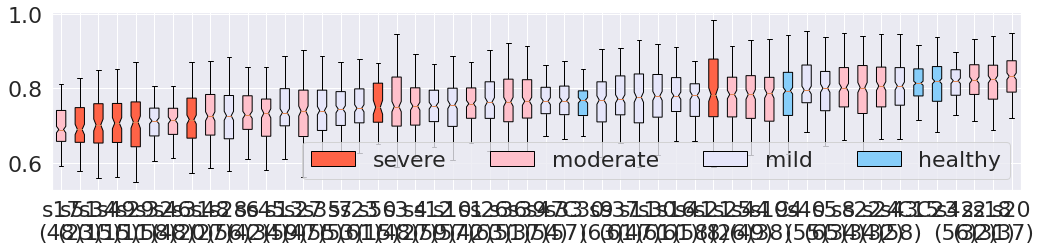

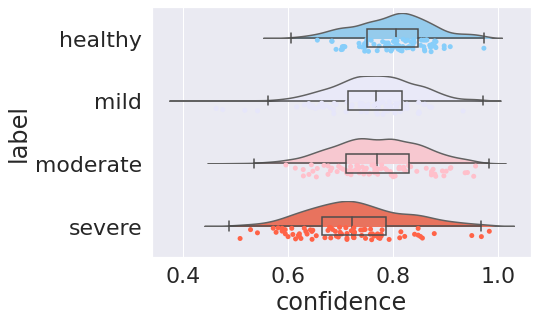

In [35]:
if True:
    plot_columns = ['prob_cal_0','prob_cal_1','prob_cal_2','prob_cal_3','prob_cal_4','seq_prob','mean_seq_prob','mean_motion_seq_prob','mean_non_motion_seq_prob']
    plot_columns = ['mean_seq_prob','mean_motion_seq_prob','mean_non_motion_seq_prob']
    for i,col in enumerate(plot_columns):
#         if i<5:
#             print(i, primatives[i])
        try:
            final.reset_index(drop=True, inplace=True)
            final['sort'] = final[col].map(lambda x:np.nanmedian(x))
            final['sort'].fillna(value=np.nanmean(final['sort']))
            final = final.sort_values(by='sort')

            final.reset_index(drop=True, inplace=True)
            final[col] = final[col].map(remove_nan)


            fig, axes = plt.subplots(1,1,figsize=(15,4))

            color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'lavender','severe':'tomato'}

            colors = final.Severity.map(lambda x: color_dict[x])

            bp = axes.boxplot(final[col],patch_artist = True,notch ='True', showfliers=False,whis=0.9)

            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)

            def x_tick(x):
                if np.isnan(x[1]):
                    return f'{x[0]}'
                else:
                    return f'{x[0]}\n({int(x[1])})'
            axes.set_xticklabels(final[['sub','FM Score']].apply(lambda x: x_tick(x),axis=1).values)
#             axes.set_ylim(0.94,1.01)

            print('generating individual plot')
            id_1 = final[final.Severity=='severe'].index[0]
            id_2 = final[final.Severity=='moderate'].index[0]    
            id_3 = final[final.Severity=='mild'].index[0]
            id_4 = final[final.Severity=='healthy'].index[0]

            axes.legend([bp["boxes"][id_1], bp["boxes"][id_2],bp["boxes"][id_3],bp["boxes"][id_4]], ['severe', 'moderate','mild','healthy'],
                        ncol=4,
                        loc='lower right',)
            #plt.show()
            plt.tight_layout()
            plt.savefig(f'./plot/{col}_{activity}_seg_indivisual_box_dirichlet.png')
            
            # Creating dataset
            data_1 = severity_confi[col][2]
            data_2 = severity_confi[col][1]
            data_3 = severity_confi[col][0]
            data_4 = np.hstack(healthy_prob[col].values)
            data = [data_1, data_2, data_3, data_4]


            fig = plt.figure(figsize =(8, 5))
            data_df = pd.DataFrame({'label':['severe']*len(severity_confi[col][2]) +\
                                            ['moderate']*len(severity_confi[col][1]) +\
                                            ['mild']*len(severity_confi[col][0]) +\
                                            ['healthy']*np.hstack(healthy_prob[col].values).shape[0],
                                    'confidence':[x for xs in data for x in xs]
                                   })
            data_df.sort_values('label',ascending=True,inplace=True)
            sns.set_style('white')
            palette = {"healthy": "lightskyblue", "mild": "lavender", "moderate": "pink", "severe":"tomato"}

            print('generating group plot')
            sns.set(font_scale = 2)
            ax = sns.violinplot(y="label", x="confidence", data=data_df,
                                palette=palette,
                                scale="width", inner=None)
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            for violin in ax.collections:
                bbox = violin.get_paths()[0].get_extents()
                x0, y0, width, height = bbox.bounds
                violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))


            sns.boxplot(y="label", x="confidence", data=data_df, saturation=1, showfliers=False, 
                        width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
            old_len_collections = len(ax.collections)
            data_sampled = data_df.groupby('label').agg({'confidence':lambda x: list(np.random.choice(np.hstack(x.values),size=80))})
            data_sampled.reset_index(drop=False,inplace=True)

            sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,
                          size=5, jitter=0.1, ax=ax)
            for dots in ax.collections[old_len_collections:]:
                dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            #plt.title(f"confidence distribution by severity level({col} - {activity})", fontsize=20)
            plt.tight_layout()
            plt.savefig(f'./plot/{col}_{activity}_seg_violinplot_dirichlet.png')
            # plt.show()
        except Exception as e:
            print(e)


# generate correlation plot

all


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeW

pearson correlation
              motion  non_motion       all  FM Score
motion      1.000000    0.228480  0.782826  0.803577
non_motion  0.228480    1.000000  0.708972  0.210600
all         0.782826    0.708972  1.000000  0.688211
FM Score    0.803577    0.210600  0.688211  1.000000
spearman correlation
              motion  non_motion       all  FM Score
motion      1.000000    0.281589  0.850195  0.765131
non_motion  0.281589    1.000000  0.680743  0.170651
all         0.850195    0.680743  1.000000  0.662230
FM Score    0.765131    0.170651  0.662230  1.000000

 brushing
pearson correlation
              motion  non_motion       all  FM Score
motion      1.000000   -0.240652  0.193798  0.315636
non_motion -0.240652    1.000000  0.822528 -0.139023
all         0.193798    0.822528  1.000000  0.075278
FM Score    0.315636   -0.139023  0.075278  1.000000

 combing
pearson correlation
              motion  non_motion       all  FM Score
motion      1.000000    0.471775  0.750717  0.6065

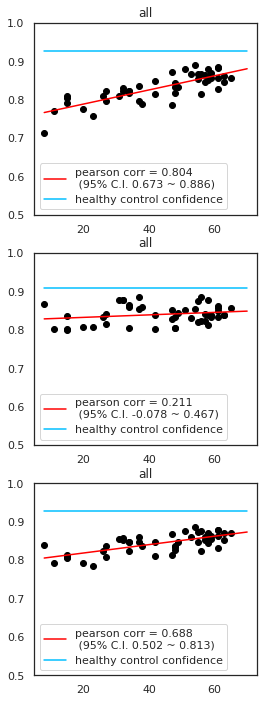

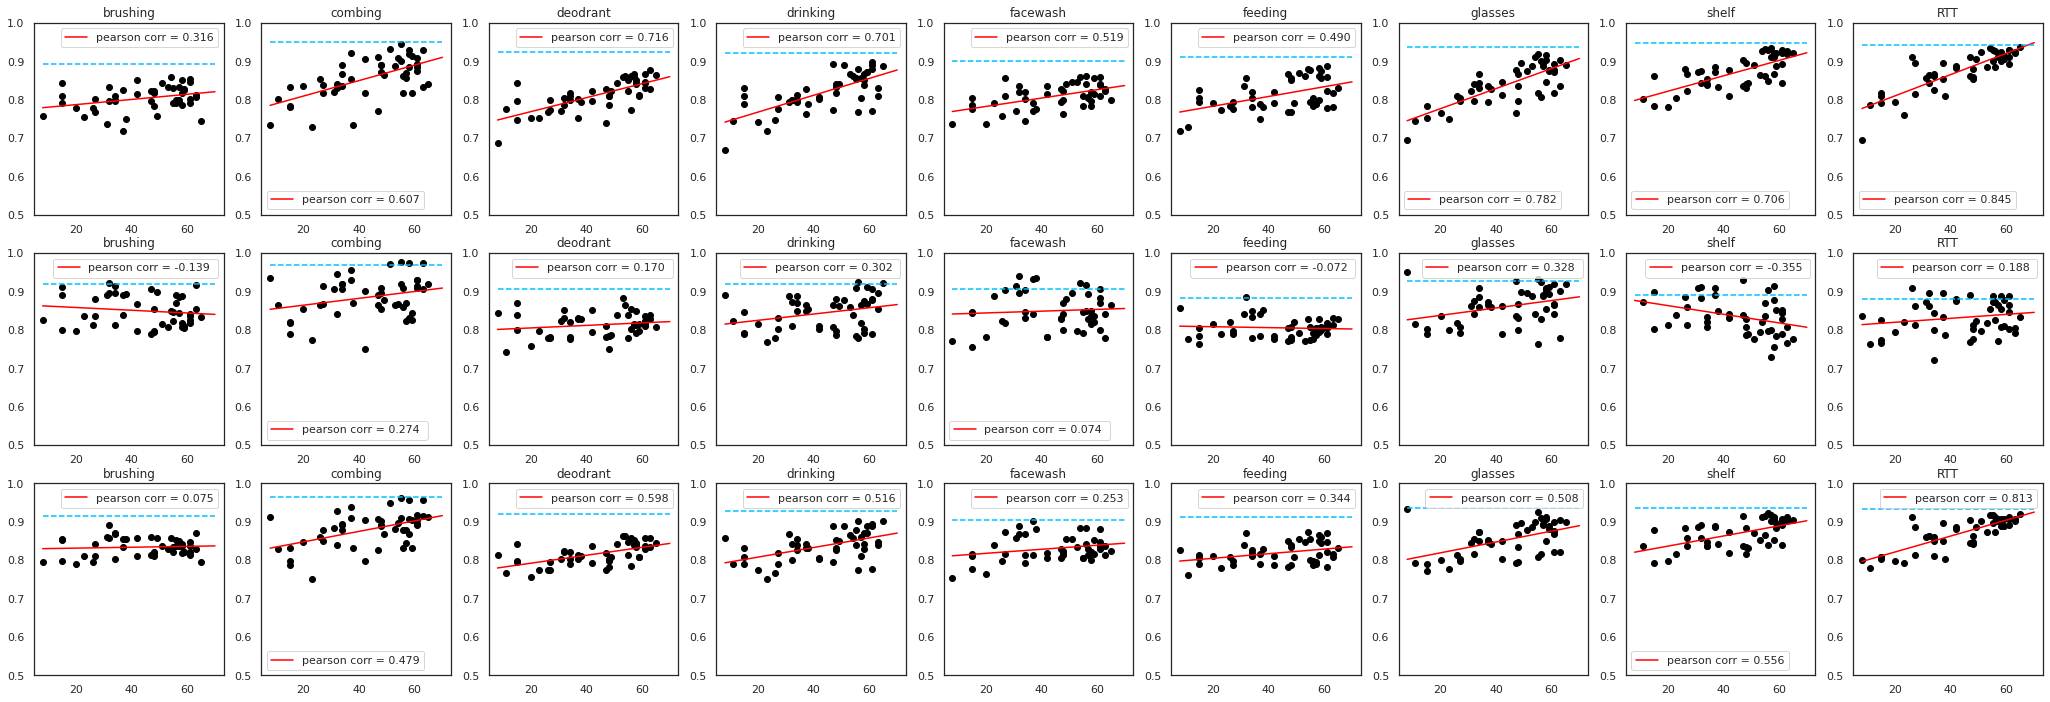

In [26]:
## CER model

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

corr_dict = {}
confidence_score = {}
subject_RTT = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
subject_other = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
                "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
healthy_df = None
activities = ['all',]
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']


primatives = {0:'idle', 1: 'reach', 2: 'reposition', 3: 'stabilize', 4: 'transport'}
def remove_nan(x):
    x = np.array(x)
#     print(x.shape)
#     print(np.sum(np.isnan(x)))
    return x[~(np.isnan(x))]


    
for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        try:
            if activity=='RTT':
                data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_cer_model._stroke.p')
    #             data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_cer_model.p')

            else:
                data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model._stroke.p')
    #             data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() 
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

            probs_cal.append(data_dict['probs'])
            
    #         temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
            temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
            temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)
        
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            balanced_acc = []
            f1_score = []
            recall_score = []
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j] 
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

                probs_cal.append(data_dict['probs'])
            
                balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),))
                f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                    data_dict['probs'][j].argmax(axis=0),
                                                   average = 'macro'
                                                          )
                                    )
                recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                           data_dict['probs'][j].argmax(axis=0),
                                                           average='macro'
                                                          )
                                    )
        except Exception as e:
            print(e)
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
        temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
        temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
        temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
        temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
        temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
               
        if healthy_df is None:
            healthy_df = temp
        else:
            healthy_df = pd.concat([healthy_df,temp],ignore_index=True)

        
    prob = df.groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
    
    print('pearson correlation')
    print(final[['motion','non_motion','all','FM Score']].corr(method='pearson'))
    print('spearman correlation')
    print(final[['motion','non_motion','all','FM Score']].corr(method='spearman'))
    
    fig, axes = plt.subplots(3,1,figsize=(4,3*4))
    axes[0].scatter(final['FM Score'],final['motion'], color='black')
    axes[0].set_title(activity)
    axes[0].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['motion'].values,final['FM Score'].values)
    axes[0].plot(x, line, '-', color='red',
                                             label = "pearson corr = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '-', color='deepskyblue',label='healthy control confidence')
    
    axes[1].scatter(final['FM Score'],final['non_motion'], color='black')
    axes[1].set_title(activity)
    axes[1].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
    axes[1].plot(x, line, '-', color='red',
                                             label = "pearson corr = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[1].plot(x, [healthy_df.mean_non_motion_seq_prob.mean()]*5, '-', color='deepskyblue',label='healthy control confidence')
    
    axes[2].scatter(final['FM Score'],final['all'], color='black')
    axes[2].set_title(activity)
    axes[2].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
    axes[2].plot(x, line, '-', color='red',
                                             label = "pearson corr = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo, hi))
    axes[2].plot(x, [healthy_df.mean_seq_prob.mean()]*5, '-', color='deepskyblue',label='healthy control confidence')
    
    for i in range(3):
        axes[i].legend()
        
    
    fig, axes = plt.subplots(3,len(acts),figsize=(len(acts)*4,3*4))
    for index,a in enumerate(acts):
        print('\n', a )
        prob = df[df['act']==a].groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
        prob.reset_index(drop=False,inplace=True)
        fm_score = pd.read_csv('./FM_scores_2.csv')
        fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
        fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
        final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
        final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
        final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
        final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))

        print('pearson correlation')
        print(final[['motion','non_motion','all','FM Score']].corr(method='pearson'))
#         print('spearman correlation')
#         print(final[['motion','non_motion','all','FM Score']].corr(method='spearman'))

        axes[0][index].scatter(final['FM Score'],final['motion'], color='black')
        axes[0][index].set_title(a)
        axes[0][index].set_ylim(0.5,1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[0][index].plot(x, line, '-', color='red',
                                                 label = "pearson corr = {:.3f}".format(final[['motion','non_motion','all','FM Score']].corr(method='pearson')['FM Score']['motion']))
        axes[0][index].plot(x, [healthy_df[healthy_df['act']==a].mean_motion_seq_prob.mean()]*5, '--', color='deepskyblue',)
    
        axes[1][index].scatter(final['FM Score'],final['non_motion'], color='black')
        axes[1][index].set_title(a)
        axes[1][index].set_ylim(0.5,1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[1][index].plot(x, line, '-', color='red',
                                                 label = "pearson corr = {:.3f} ".format(final[['motion','non_motion','all','FM Score']].corr(method='pearson')['FM Score']['non_motion']))
        axes[1][index].plot(x, [healthy_df[healthy_df['act']==a].mean_non_motion_seq_prob.mean()]*5, '--', color='deepskyblue',)
    
        axes[2][index].scatter(final['FM Score'],final['all'], color='black')
        axes[2][index].set_title(a)
        axes[2][index].set_ylim(0.5,1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
        x = np.linspace(8, 70, num=5)
        line = [slope*ii for ii in x] + intercept
        axes[2][index].plot(x, line, '-', color='red',
                                                 label = "pearson corr = {:.3f}".format(final[['motion','non_motion','all','FM Score']].corr(method='pearson')['FM Score']['all']))
        axes[2][index].plot(x, [healthy_df[healthy_df['act']==a].mean_seq_prob.mean()]*5, '--', color='deepskyblue',)
    
        for i in range(3):
            axes[i][index].legend()



In [18]:
#https://stats.stackexchange.com/questions/18887/how-to-calculate-a-confidence-interval-for-spearmans-rank-correlation
import math
r = 0.684848
num = 10
def confidence_interval_spearsman(r,num):
    stderr = math.sqrt((1+ r*r/2)/(num-3)) #1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper, r
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['motion'],48))
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['non_motion'],48))
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['all'],48))


(0.6565671251262943, 0.8976362098939654, 0.8087260182128757)
(-0.1640346930482093, 0.3979286957971453, 0.1271359679286617)
(0.5802867760147616, 0.8683053639217562, 0.7592842529072851)


In [5]:
## loss model


corr_dict = {}
confidence_score = {}
subject_RTT = ["C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14",\
           "C15", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26", "C27", "C28", "C29",\
           "C30", "C31", "C32"]
subject_other = ["C4","C5", "C7", "C9", "C11", "C12", "C15", "C19", "C20", "C22",\
                "C23", "C24", "C25", "C26", "C27", "C28", "C29", "C30", "C31","C32"]

df = None
healthy_df = None
activities = ['all',]
acts = ['brushing','combing','deodrant','drinking','facewash','feeding','glasses','shelf','RTT']


primatives = {0:'idle', 1: 'reach', 2: 'reposition', 3: 'stabilize', 4: 'transport'}
def remove_nan(x):
    x = np.array(x)
#     print(x.shape)
#     print(np.sum(np.isnan(x)))
    return x[~(np.isnan(x))]


    
for activity in activities:
    print(activity)
    df = None
    n_splits = len(os.listdir(f'./result/sensors_{activity}')) if activity!='RTT' else len(os.listdir(f'./result/sensors_2')) 
    val_len=2
    probs_cal = []
    prob = []
    for i in range(1,n_splits+1):
        try:
            if activity=='RTT':
                data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_loss_model._stroke.p')
    #             data_dict = unpickling('./result/sensors_2/in_channel-77_param_search-True_dataset-sensors_2_split-'+str(i)+'/predictions_cer_model.p')

            else:
                data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model._stroke.p')
    #             data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_cer_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j].numpy() 
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

            probs_cal.append(data_dict['probs'])
            
    #         temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],'prob':data_dict['probs']})
            temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
            temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
            temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
            temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
            temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
            
            #print(temp.shape)
            if df is None:
                df=temp
            else:
                
                df = pd.concat([df,temp],ignore_index=True)
        except Exception as e:
            print(e)
        
        try:
            data_dict = unpickling(f'./result/sensors_{activity}/in_channel-77_param_search-True_dataset-sensors_{activity}_split-'+str(i)+'/predictions_loss_model.p')
            data_dict['sub'] = []
            data_dict['activity'] = []
            data_dict['rep'] = []
            for i in range(5):
                data_dict[f'prob_cal_{i}'] = []

            balanced_acc = []
            f1_score = []
            recall_score = []
            for j in range(len(data_dict['name'])):
                data_dict['probs'][j] = softmax(data_dict['probs'][j][0],axis = 0)
                split_name = data_dict['name'][j].split('_') #data_dict['name']: e.g. s6_RTT_SB_mod_RTT right side 3
                data_dict['sub'].append(split_name[0])
                for a in acts:
                    if a=='deodrant':
                        if 'deodrant' in data_dict['name'][j] or 'deodorant' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    elif a=='facewash':
                        if 'face' in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                    else:
                        if a in data_dict['name'][j]:
                            data_dict['activity'].append(a)
                data_dict['rep'].append(data_dict['name'][j][-1])
                data_dict['gt'][j] = data_dict['gt'][j].numpy() #no need to edit  data_dict['r_pred'] &  data_dict['probs']
                if val_len<1.:
                    #print('h')
                    probs, labels, indices = remove_dups(data_dict['r_pred'][j],data_dict['probs'][j],val_len=val_len,method='mean',return_idx=True)
                    data_dict['r_pred'][j] = ''.join(labels.astype('str'))
                    data_dict['probs'][j] = probs
                    data_dict['gt'][j] = labels#data_dict['gt'][j].numpy()[indices]

                else:
                    data_dict['gt'][j] = data_dict['gt'][j] 
                    data_dict['prob_cal_0'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==0])
                    data_dict['prob_cal_1'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==1])
                    data_dict['prob_cal_2'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==2]) 
                    data_dict['prob_cal_3'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==3])
                    data_dict['prob_cal_4'].append(data_dict['probs'][j].max(axis=0)[data_dict['probs'][j].argmax(axis=0)==4])

                probs_cal.append(data_dict['probs'])
            
                balanced_acc.append(balanced_acc_5_cls(data_dict['gt'][j], 
                                                       data_dict['probs'][j].argmax(axis=0),))
                f1_score.append(metrics.f1_score(data_dict['gt'][j], 
                                                    data_dict['probs'][j].argmax(axis=0),
                                                   average = 'macro'
                                                          )
                                    )
                recall_score.append(metrics.recall_score(data_dict['gt'][j], 
                                                           data_dict['probs'][j].argmax(axis=0),
                                                           average='macro'
                                                          )
                                    )
        except Exception as e:
            print(e)
            
        temp = pd.DataFrame({'sub':data_dict['sub'],'act':data_dict['activity'],'rep':data_dict['rep'],'gt':data_dict['gt'],'pred':data_dict['r_pred'],
                                 'prob':data_dict['probs'],'probs_cal':data_dict['probs'], 
                                 'prob_cal_0':data_dict['prob_cal_0'], 'prob_cal_1':data_dict['prob_cal_1'], 'prob_cal_2':data_dict['prob_cal_2'], 'prob_cal_3':data_dict['prob_cal_3'], 'prob_cal_4':data_dict['prob_cal_4']
                                })
        temp['seq_prob'] = temp.probs_cal.map(collate_confidence)
        temp['seq_prob_no_dup'] = temp.prob.map(collate_confidence)
        temp['mean_seq_prob'] = temp.seq_prob.map(lambda x:np.mean(x))
        temp['mean_motion_seq_prob'] = temp[['prob_cal_1','prob_cal_2', 'prob_cal_4']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
        temp['mean_non_motion_seq_prob'] = temp[['prob_cal_0','prob_cal_3']].apply(lambda x: np.mean(np.hstack(x)),axis=1)
               
        if healthy_df is None:
            healthy_df = temp
        else:
            healthy_df = pd.concat([healthy_df,temp],ignore_index=True)

        
    prob = df.groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
    
    print('pearson correlation')
    print(final[['motion','non_motion','all','FM Score']].corr(method='pearson'))
#     print('spearman correlation')
#     print(final[['motion','non_motion','all','FM Score']].corr(method='spearman'))
    
    
#     for index,a in enumerate(acts):
#         print('\n', a )
#         prob = df[df['act']==a].groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
#                                   'mean_seq_prob':lambda x: list(np.hstack(x.values)),
#                                   'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
#                                   'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
#                                   'prob_cal_0':lambda x: list(np.hstack(x.values)),
#                                   'prob_cal_1':lambda x: list(np.hstack(x.values)),
#                                   'prob_cal_2':lambda x: list(np.hstack(x.values)),
#                                   'prob_cal_3':lambda x: list(np.hstack(x.values)),
#                                   'prob_cal_4':lambda x: list(np.hstack(x.values)),
#                                  })
    
#         prob.reset_index(drop=False,inplace=True)
#         fm_score = pd.read_csv('./FM_scores_2.csv')
#         fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
#         fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
#         final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
#         final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
#         final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
#         final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
# #         print('pearson correlation')
# #         corr = final[['motion','non_motion','all','FM Score']].corr(method='pearson')
# #         print(corr)
#         HC_confidence_by_sub = healthy_df[healthy_df['act']==a].groupby('sub').mean()
#         HC_confidence_by_sub.reset_index(inplace=True, drop=False)

#         y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
#         x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
#         r, p, lo, hi = pearsonr_ci(y,x)
#         stroke_performance_dict[a]['motion correlation'] = r
#         stroke_performance_dict[a]['motion correlation low'] = lo
#         stroke_performance_dict[a]['motion correlation up'] = hi
        
        

all


/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.

pearson correlation
              motion  non_motion       all  FM Score
motion      1.000000    0.270232  0.757340  0.790463
non_motion  0.270232    1.000000  0.782376  0.213494
all         0.757340    0.782376  1.000000  0.635568
FM Score    0.790463    0.213494  0.635568  1.000000


In [7]:
healthy_df.to_pickle('healthy_raw.pkl')

In [8]:
df[['sub', 'act','rep', 'mean_seq_prob', 'mean_motion_seq_prob',
       'mean_non_motion_seq_prob']].to_pickle('stroke_raw.pkl')

In [18]:
stroke_performance_dict

{'RTT': {'motion class acc': 0.6441969906525812,
  'motion class precision': 0.7359061536866315,
  'motion correlation': 0.8487080232363293,
  'motion correlation low': 0.7517927766321209,
  'motion correlation up': 0.9097315906126773,
  'n_unique_records': 1210,
  'n_unique_subjects': 50,
  'overall acc': 0.6180207616721922,
  'overall precision': 0.5945768358683561},
 'brushing': {'motion class acc': 0.483066782225882,
  'motion class precision': 0.37252303792737607,
  'motion correlation': 0.40872924085737816,
  'motion correlation low': 0.1582924623708636,
  'motion correlation up': 0.6097570293030414,
  'n_unique_records': 1135,
  'n_unique_subjects': 50,
  'overall acc': 0.4939374269535607,
  'overall precision': 0.4672550976123574},
 'combing': {'motion class acc': 0.6205520419953136,
  'motion class precision': 0.5790826896591633,
  'motion correlation': 0.598585616026815,
  'motion correlation low': 0.3962073896791742,
  'motion correlation up': 0.7454957731056362,
  'n_unique

In [41]:
final.shape

(51, 15)

In [54]:
final[['sub','FM Score', 'Severity', 'motion', 'all','non_motion']].to_csv('final.csv',index=False)

In [43]:
HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)
HC_confidence_by_sub.to_csv('healthy.csv',index=False)

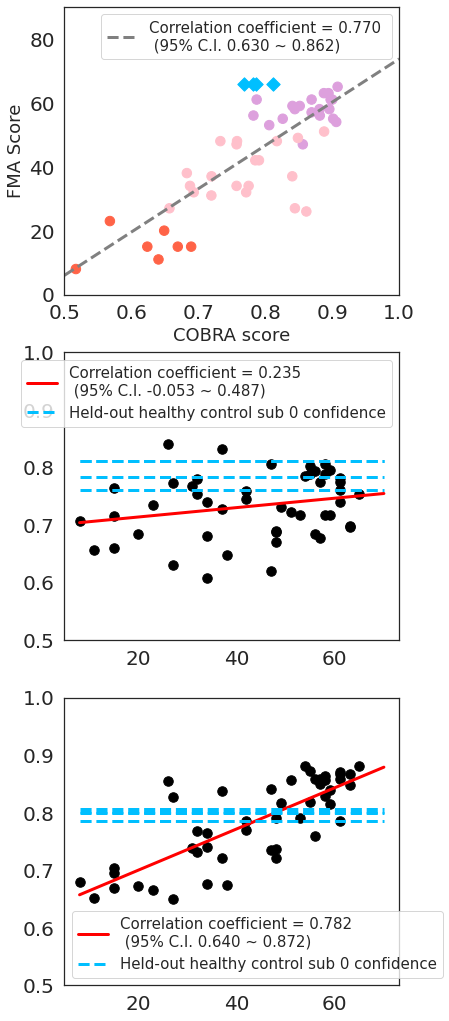

In [129]:
HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)
color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = final.Severity.map(color_dict)
sns.set(style='white')
if True:
    fig, axes = plt.subplots(3,1,figsize=(6,3*6))
    axes[0].scatter(final['motion'], final['FM Score'], color=color,s=90)
    axes[0].scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=90)
    #axes[0].set_title(activity)
    axes[0].set_xlim(0.5,1)
    axes[0].set_ylim(0,90)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,1, num=5)
    line = [slope*ii for ii in x] + intercept
    axes[0].plot(x, line, '--', color='grey',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    axes[0].set_xlabel('COBRA score',fontsize=18)
    axes[0].set_ylabel('FMA Score',fontsize=18)
    
    axes[1].scatter(final['FM Score'],final['non_motion'], color='black',s=90)
    #axes[1].set_title(activity)
    axes[1].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
    axes[1].plot(x, line, '-', color='red',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[1].plot(x, [healthy_df.mean_non_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    for i in range(4):
        if i==0:
            axes[1].plot(x, [HC_confidence_by_sub['mean_non_motion_seq_prob'][i]]*5, '--', linewidth=3, color='deepskyblue',label=f'Held-out healthy control sub {i} confidence')
        else:
            axes[1].plot(x, [HC_confidence_by_sub['mean_non_motion_seq_prob'][i]]*5, '--', linewidth=3, color='deepskyblue')#,label=f'Held-out healthy control sub {i} confidence')

    axes[2].scatter(final['FM Score'],final['all'], color='black',s=90)
    #axes[2].set_title(activity)
    axes[2].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
    axes[2].plot(x, line, '-', color='red',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[2].plot(x, [healthy_df.mean_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    for i in range(4):
        if i==0:
            axes[2].plot(x, [HC_confidence_by_sub['mean_seq_prob'][i]]*5, '--', linewidth=3, color='deepskyblue',label=f'Held-out healthy control sub {i} confidence')
        else:
            axes[2].plot(x, [HC_confidence_by_sub['mean_seq_prob'][i]]*5, '--', linewidth=3, color='deepskyblue')#,label=f'Held-out healthy control sub {i} confidence')

    for i in range(3):
        axes[i].legend(fontsize=15)
        axes[i].xaxis.set_tick_params(labelsize=20)
        axes[i].yaxis.set_tick_params(labelsize=20)
    plt.savefig('plot/sensor_motion.png')



 brushing

 combing

 deodrant

 drinking

 facewash

 feeding

 glasses

 shelf

 RTT


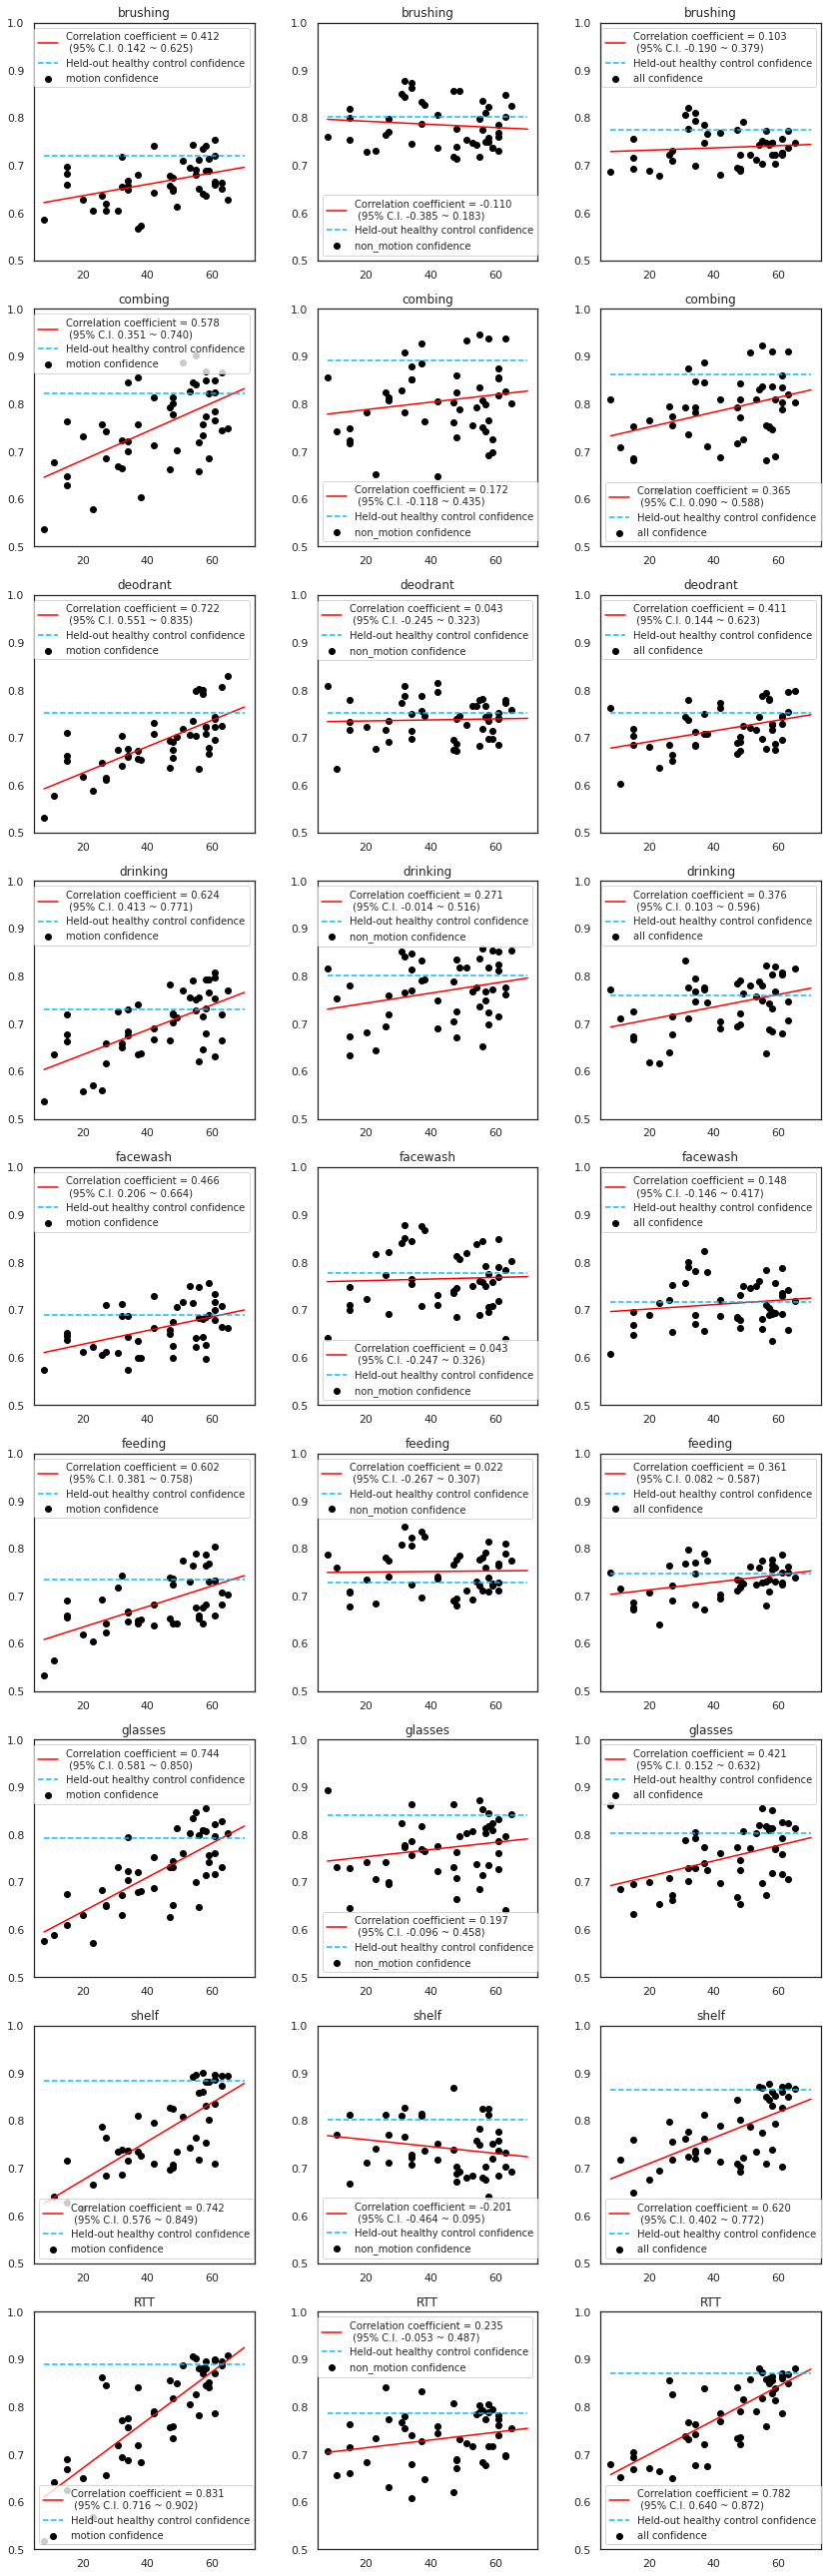

In [43]:
fig, axes = plt.subplots(len(acts),3,figsize=(3*4,len(acts)*4))

for index,a in enumerate(acts):
    print('\n', a )
    prob = df[df['act']==a].groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    fm_score = pd.read_csv('./FM_scores_2.csv')
    fm_score = fm_score[['Stroke Pt Number','Severity','Side of body affected','FM Score','sub_id_2']]
    fm_score.columns = ['Stroke Pt Number','Severity','Side of body affected','FM Score','sub']
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))

    axes[index][0].scatter(final['FM Score'],final['motion'], color='black', label='motion confidence')
    axes[index][0].set_title(a)
    axes[index][0].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['motion'].values,final['FM Score'].values)
    axes[index][0].plot(x, line, '-', color='red',
                        label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[index][0].plot(x, [healthy_df[healthy_df['act']==a].mean_motion_seq_prob.mean()]*5, '--', color='deepskyblue',
                       label=f'Held-out healthy control confidence')
 
            
            
    axes[index][1].scatter(final['FM Score'],final['non_motion'], color='black', label='non_motion confidence')
    axes[index][1].set_title(a)
    axes[index][1].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
    axes[index][1].plot(x, line, '-', color='red',
                        label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[index][1].plot(x, [healthy_df[healthy_df['act']==a].mean_non_motion_seq_prob.mean()]*5, '--', color='deepskyblue',
                       label=f'Held-out healthy control confidence')
    
    axes[index][2].scatter(final['FM Score'],final['all'], color='black', label='all confidence')
    axes[index][2].set_title(a)
    axes[index][2].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
    axes[index][2].plot(x, line, '-', color='red',
                        label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[index][2].plot(x, [healthy_df[healthy_df['act']==a].mean_seq_prob.mean()]*5, '--', color='deepskyblue',
                        label=f'Held-out healthy control confidence')
    
    
    for i in range(3):
        axes[index][i].legend(fontsize=10)

plt.tight_layout()
plt.savefig('plot/sensor_train_combined_eval_single.pdf')



In [13]:
acts

['brushing',
 'combing',
 'deodrant',
 'drinking',
 'facewash',
 'feeding',
 'glasses',
 'shelf',
 'RTT']

In [41]:
stroke_performance_df = pd.DataFrame(stroke_performance_dict).T
stroke_performance_df.columns = ['stroke_'+ x for x in stroke_performance_df.columns]
healthy_performance_df = pd.DataFrame(healthy_performance_dict).T
healthy_performance_df.columns = ['healthy_'+ x for x in healthy_performance_df.columns]
performance_df = pd.concat([stroke_performance_df,healthy_performance_df],axis=1)
performance_df.sort_values(by='healthy_motion class acc',inplace=True)

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


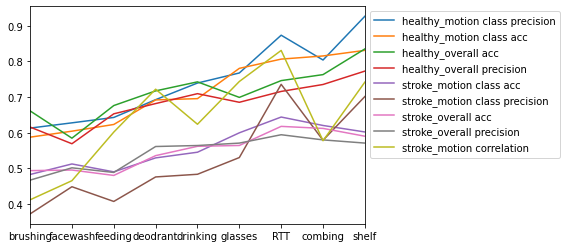

In [43]:
performance_df[['healthy_motion class precision','healthy_motion class acc',
               'healthy_overall acc','healthy_overall precision',
               'stroke_motion class acc','stroke_motion class precision','stroke_overall acc',
               'stroke_overall precision','stroke_motion correlation']].plot()

plt.legend(bbox_to_anchor = (1,1))

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


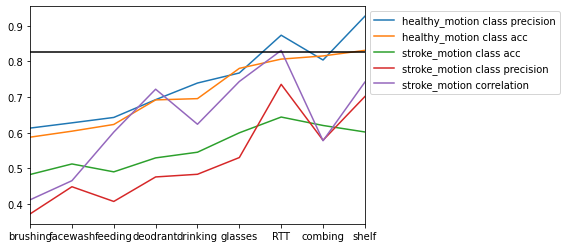

In [49]:
performance_df[['healthy_motion class precision','healthy_motion class acc',
               'stroke_motion class acc','stroke_motion class precision',
                'stroke_motion correlation']].plot()
plt.axhline(y=0.826,color = 'black')
plt.legend(bbox_to_anchor = (1,1))

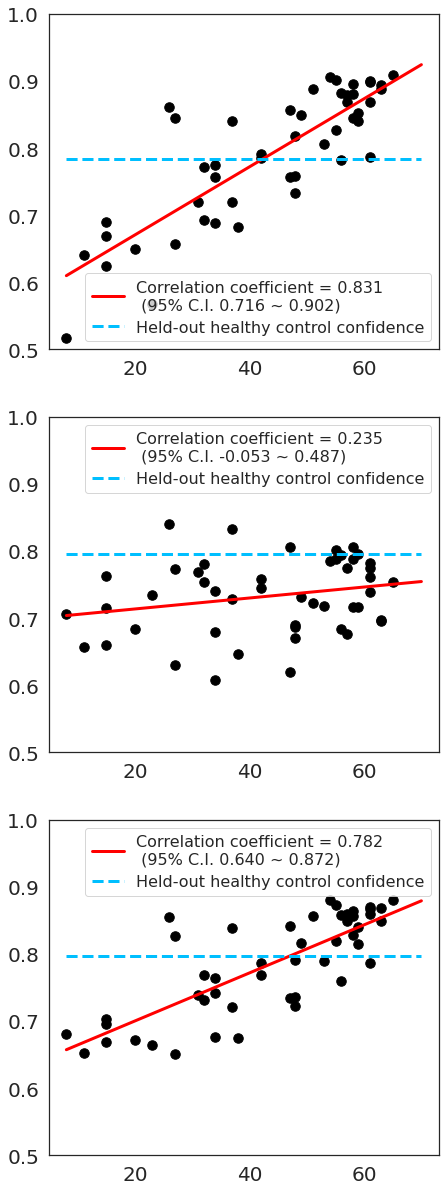

In [127]:
if True:
    fig, axes = plt.subplots(3,1,figsize=(7,3*7))
    axes[0].scatter(final['FM Score'],final['motion'], color='black',s=90)
    #axes[0].set_title(activity)
    axes[0].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['motion'].values,final['FM Score'].values)
    axes[0].plot(x, line, '-', color='red',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    axes[1].scatter(final['FM Score'],final['non_motion'], color='black',s=90)
    #axes[1].set_title(activity)
    axes[1].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
    axes[1].plot(x, line, '-', color='red',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[1].plot(x, [healthy_df.mean_non_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    axes[2].scatter(final['FM Score'],final['all'], color='black',s=90)
    #axes[2].set_title(activity)
    axes[2].set_ylim(0.5,1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
    x = np.linspace(8, 70, num=5)
    line = [slope*ii for ii in x] + intercept
    r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
    axes[2].plot(x, line, '-', color='red',linewidth=3,
                                             label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    axes[2].plot(x, [healthy_df.mean_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    for i in range(3):
        axes[i].legend(fontsize=16)
        axes[i].xaxis.set_tick_params(labelsize=20)
        axes[i].yaxis.set_tick_params(labelsize=20)
    plt.savefig('plot/sensor_motion.png')


Correlation coefficient = 0.814 
 (95% C.I. [0.700,0.888])


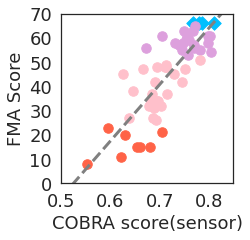

In [68]:
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)
color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = final.Severity.map(color_dict)
sns.set(style='white')
if True:
    fig, axes = plt.subplots(1,1,figsize=(3.5,3.5))
    plt.rcParams['font.family'] = 'Helvetica'
    plt.scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=90, label='healthy(held-out)')
    plt.scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=90,label='mild')
    plt.scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=90,label='moderate')
    plt.scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=90,label='severe')
#     plt.scatter(HC_confidence_by_sub.mean_non_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=90, label='healthy(held-out)')
#     plt.scatter(final[final['Severity']=='mild']['non_motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=90,label='mild')
#     plt.scatter(final[final['Severity']=='moderate']['non_motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=90,label='moderate')
#     plt.scatter(final[final['Severity']=='severe']['non_motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=90,label='severe')
    plt.xlim(0.5,0.85)
    plt.ylim(0,70)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
#     y = np.concatenate((final['non_motion'].values, HC_confidence_by_sub.mean_non_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,0.9, num=5)
    line = [slope*ii for ii in x] + intercept
    plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    
# fig, axes = plt.subplots(1,1,figsize=(7,7))
# plt.scatter(final['FM Score'],final['motion'], color='black',s=90)
# # plt.scatter(final['FM Score'],final['non_motion'], color='black',s=90)
# # plt.scatter(final['FM Score'],final['all'], color='black',s=90)
# plt.ylim(0.5,1)
# slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
# # slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
# # slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
# x = np.linspace(8, 70, num=5)
# line = [slope*ii for ii in x] + intercept
# r, p, lo, hi = pearsonr_ci(final['motion'].values,final['FM Score'].values)
# # r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
# # r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
# plt.plot(x, line, '-', color='red',linewidth=3,
#                                              label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
# plt.plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
# # plt.plot(x, [healthy_df.mean_non_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
# # plt.plot(x, [healthy_df.mean_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
# plt.title("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),fontsize=18,fontname='Helvetica')
print("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi))
plt.xlabel('COBRA score(sensor)',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
#plt.legend(fontsize=15,loc=4)#bbox_to_anchor=(1,0.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('plot/sensor_motion.pdf')
# plt.savefig('plot/sensor_non_motion.pdf')
# plt.savefig('plot/sensor_all.png')

    

In [46]:
healthy_df.to_csv('healthy_raw.csv',index=False)

In [52]:
df.columns

Index(['sub', 'act', 'rep', 'gt', 'pred', 'prob', 'probs_cal', 'prob_cal_0',
       'prob_cal_1', 'prob_cal_2', 'prob_cal_3', 'prob_cal_4', 'seq_prob',
       'seq_prob_no_dup', 'mean_seq_prob', 'mean_motion_seq_prob',
       'mean_non_motion_seq_prob'],
      dtype='object')

In [55]:
df[['sub', 'act','rep', 'mean_seq_prob', 'mean_motion_seq_prob',
       'mean_non_motion_seq_prob']].to_csv('stroke_raw.csv',index=False)

brushing
combing
deodrant
drinking
facewash
feeding
glasses
shelf
RTT


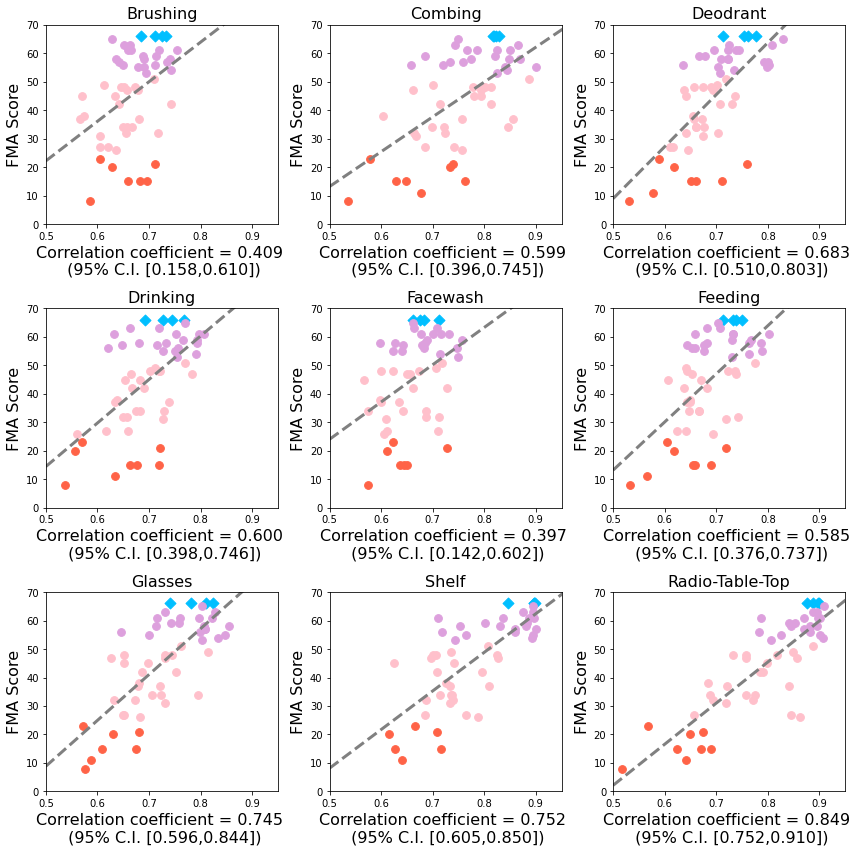

In [44]:
import seaborn as sns

fig,axes = plt.subplots(3,3,figsize=(12,12))


color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = final.Severity.map(color_dict)
sns.set(style='white')
for i,a in enumerate(acts):
    print(a)
    HC_confidence_by_sub = healthy_df[healthy_df['act']==a].groupby('sub').mean()
    HC_confidence_by_sub.reset_index(inplace=True, drop=False)

    
    prob = df[df['act']==a].groupby('sub').agg({'seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'mean_non_motion_seq_prob':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_0':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_1':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_2':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_3':lambda x: list(np.hstack(x.values)),
                                  'prob_cal_4':lambda x: list(np.hstack(x.values)),
                                 })
    
    prob.reset_index(drop=False,inplace=True)
    final = pd.merge(prob,fm_score[['sub','FM Score','Severity']],on='sub')    
    final['motion'] = final.mean_motion_seq_prob.map(lambda x:np.nanmean(x))
    final['all'] = final.mean_seq_prob.map(lambda x:np.nanmean(x))
    final['non_motion'] = final.mean_non_motion_seq_prob.map(lambda x:np.nanmean(x))
    
    plot_i = i//3
    plot_j = i%3
    axes[plot_i][plot_j].scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=60, label='healthy(held-out)')
    axes[plot_i][plot_j].scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=60,label='mild')
    axes[plot_i][plot_j].scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=60,label='moderate')
    axes[plot_i][plot_j].scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=60,label='severe')
    axes[plot_i][plot_j].set_xlim(0.5,0.95)
    axes[plot_i][plot_j].set_ylim(0,70)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,0.99, num=5)
    line = [slope*ii for ii in x] + intercept
    axes[plot_i][plot_j].plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    axes[plot_i][plot_j].set_xlabel("Correlation coefficient = {:.3f} \n (95% C.I. [{:.3f},{:.3f}])".format(r, lo,hi),fontsize=16)
    if a=='deodrant':
        axes[plot_i][plot_j].set_title('Deodorant',fontsize=16)
    if a=='RTT':
        axes[plot_i][plot_j].set_title('Radio-Table-Top',fontsize=16)
    else:
        axes[plot_i][plot_j].set_title(a.capitalize(),fontsize=16)
    axes[plot_i][plot_j].set_ylabel('FMA Score',fontsize=16)
  
    #axes[plot_i][plot_j].set_xticks(fontsize=16)
    #axes[plot_i][plot_j].set_yticks(fontsize=16)
plt.tight_layout()
plt.savefig('plot/per_act_sensor_motion.pdf')
# plt.savefig('plot/sensor_non_motion.png')
# plt.savefig('plot/sensor_all.png')

    

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


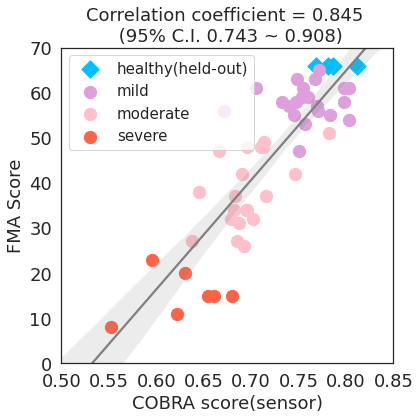

In [152]:
import seaborn as sns

HC_confidence_by_sub = healthy_df.groupby('sub').mean()
HC_confidence_by_sub.reset_index(inplace=True, drop=False)
color_dict = {'healthy': 'lightskyblue', 'moderate':'pink',  'mild': 'plum','severe':'tomato'}

color = final.Severity.map(color_dict)
sns.set(style='white')
if True:
    fig, axes = plt.subplots(1,1,figsize=(6,6))
    plt.scatter(HC_confidence_by_sub.mean_motion_seq_prob, [66]*4, marker='D',color='deepskyblue',s=150, label='healthy(held-out)')
    plt.scatter(final[final['Severity']=='mild']['motion'], final[final['Severity']=='mild']['FM Score'], color='plum',s=150,label='mild')
    plt.scatter(final[final['Severity']=='moderate']['motion'], final[final['Severity']=='moderate']['FM Score'], color='pink',s=150,label='moderate')
    plt.scatter(final[final['Severity']=='severe']['motion'], final[final['Severity']=='severe']['FM Score'], color='tomato',s=150,label='severe')
    plt.xlim(0.5,0.85)
    plt.ylim(0,70)
    y = np.concatenate((final['motion'].values, HC_confidence_by_sub.mean_motion_seq_prob.values)) 
    x = np.concatenate((final['FM Score'].values, np.array([66]*4)))
    r, p, lo, hi = pearsonr_ci(y,x)
    sns.regplot(y,x,scatter=False,truncate=False, color='gray')
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,x)
    
    x = np.linspace(0.5,1, num=5)
    line = [slope*ii for ii in x] + intercept
    #plt.plot(x, line, '--', color='grey',linewidth=3,)
                                             #label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
    #axes[0].plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
    
    
# fig, axes = plt.subplots(1,1,figsize=(7,7))
# plt.scatter(final['FM Score'],final['motion'], color='black',s=90)
# # plt.scatter(final['FM Score'],final['non_motion'], color='black',s=90)
# # plt.scatter(final['FM Score'],final['all'], color='black',s=90)
# plt.ylim(0.5,1)
# slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['motion'])
# # slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['non_motion'])
# # slope, intercept, r_value, p_value, std_err = stats.linregress(final['FM Score'],final['all'])
# x = np.linspace(8, 70, num=5)
# line = [slope*ii for ii in x] + intercept
# r, p, lo, hi = pearsonr_ci(final['motion'].values,final['FM Score'].values)
# # r, p, lo, hi = pearsonr_ci(final['non_motion'].values,final['FM Score'].values)
# # r, p, lo, hi = pearsonr_ci(final['all'].values,final['FM Score'].values)
# plt.plot(x, line, '-', color='red',linewidth=3,
#                                              label = "Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi))
# plt.plot(x, [healthy_df.mean_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
# # plt.plot(x, [healthy_df.mean_non_motion_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
# # plt.plot(x, [healthy_df.mean_seq_prob.mean()]*5, '--',linewidth=3, color='deepskyblue',label = 'Held-out healthy control confidence')
plt.title("Correlation coefficient = {:.3f} \n (95% C.I. {:.3f} ~ {:.3f})".format(r, lo,hi),fontsize=18)
plt.xlabel('COBRA score(sensor)',fontsize=18)
plt.ylabel('FMA Score',fontsize=18)
  
plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('plot/sensor_motion.png')
# plt.savefig('plot/sensor_non_motion.png')
# plt.savefig('plot/sensor_all.png')

    

In [105]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt


%matplotlib inline

# Raw Data
heights = np.array([50,52,53,54,58,60,62,64,66,67,68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,45,45,50,75,95,65,50,40,45])

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    ax.fill_between(x2, y2 + ci, y2 - ci, color="lightskyblue", edgecolor="")

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 


x = heights
y = weights
p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = weights.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)
print(t, s_err, n, x, x2, y2)
# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(x, y, resid, ax=ax)
   
# Prediction Interval
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")

plt.show()

2.1098155778331806 17.567352906495284 19 [50 52 53 54 58 60 62 64 66 67 68 70 72 74 76 55 50 45 65] [45.         45.31313131 45.62626263 45.93939394 46.25252525 46.56565657
 46.87878788 47.19191919 47.50505051 47.81818182 48.13131313 48.44444444
 48.75757576 49.07070707 49.38383838 49.6969697  50.01010101 50.32323232
 50.63636364 50.94949495 51.26262626 51.57575758 51.88888889 52.2020202
 52.51515152 52.82828283 53.14141414 53.45454545 53.76767677 54.08080808
 54.39393939 54.70707071 55.02020202 55.33333333 55.64646465 55.95959596
 56.27272727 56.58585859 56.8989899  57.21212121 57.52525253 57.83838384
 58.15151515 58.46464646 58.77777778 59.09090909 59.4040404  59.71717172
 60.03030303 60.34343434 60.65656566 60.96969697 61.28282828 61.5959596
 61.90909091 62.22222222 62.53535354 62.84848485 63.16161616 63.47474747
 63.78787879 64.1010101  64.41414141 64.72727273 65.04040404 65.35353535
 65.66666667 65.97979798 66.29292929 66.60606061 66.91919192 67.23232323
 67.54545455 67.85858586 6

/gpfs/share/apps/anaconda3/gpu/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


ValueError: Expected 2-dimensional array, got 1

<Figure size 576x432 with 1 Axes>

In [20]:
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['motion'],48))
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['non_motion'],48))
print(confidence_interval_spearsman(final[['motion','non_motion','all','FM Score']].corr(method='spearman')['FM Score']['all'],48))


(0.6390133327298742, 0.8911308307119878, 0.7975880381165613)
(-0.05905080688338931, 0.4877424883220879, 0.2326479549874057)
(0.5869917201489365, 0.870996230815436, 0.7637394449458108)


In [7]:
final.to_csv('final_result/final_loss_model.csv',index=False)

In [36]:
df

sub       act rep                                                 gt  \
0     C23  deodrant   1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1     C23  brushing   3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2     C23     shelf   4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3     C23   feeding   2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4     C30  brushing   g  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
...   ...       ...  ..                                                ...   
1535  C23  deodrant   4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1536  C30   feeding   2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1537   C4   combing   4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1538  C23   glasses   1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1539  C23  drinking   4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                  probs       acc  \
0     [[0.97716206, 0.97768456, 0.9784461, 0.9784065...  0.659829   
1     [[0.97306895, 0.9732782, 0.9742631, 0.9741367,...  0.631500   
2     [[0.9757615, 0.976199, 0.9767088, 0.97659934, ...  0.896420   
3     [[0.9744001, 0.97472167, 0.97538984, 0.9751233...  0.821429   
4     [[0.5685777, 0.51066095, 0.45845914, 0.4116740...  0.607547   
...                                                 ...       ...   
1535  [[0.9889658, 0.98818517, 0.9892837, 0.9891394,...  0.669691   
1536  [[0.9893931, 0.98872674, 0.98985136, 0.9897975...  0.648156   
1537  [[0.9906437, 0.9899958, 0.99107695, 0.9910273,...  0.873603   
1538  [[0.98907804, 0.9884034, 0.98957247, 0.9894945...  0.775478   
1539  [[0.99010247, 0.98954505, 0.99069613, 0.990700...  0.758962   

      balanced_acc  recall_score  f1_score  
0         0.653245      0.776456  0.656966  
1         0.482660      0.672250  0.509896  
2         0.746710      0.772015  0.742622  
3         0.761739      0.827050  0.765343  
4         0.584777      0.729801  0.615530  
...            ...           ...       ...  
1535      0.775604      0.845234  0.746982  
1536      0.703469      0.725631  0.683800  
1537      0.787586      0.722646  0.668911  
1538      0.679547      0.682502  0.677731  
1539      0.741379      0.774230  0.674072  

[1540 rows x 9 columns]

In [2]:
import pandas as pd
fm_score = pd.read_csv('./FM_scores_2.csv')
fm_score

Stroke Pt Number  Severity Side of body affected  FM Score Sub_id  \
0                  1  moderate                 Right        42  S0001   
1                  2  moderate                  Left        32  S0002   
2                  3  moderate                  Left        48  S0003   
3                  4  moderate                  Left        27  S0004   
4                  5      mild                  Left        65  S0005   
5                  6  moderate                 Right        42  S0006   
6                  7      mild                 Right        53  S0007   
7                  8  moderate                  Left        34  S0008   
8                  9      mild                  Left        63  S0009   
9                 10      mild                  Left        57  S0010   
10                11  moderate                 Right        47  S0011   
11                12      mild                 Right        59  S0012   
12                13      mild                 Right        59  S0013   
13                16      mild                 Right        61  S0016   
14                17  moderate                 Right        48  S0017   
15                18  moderate                  Left        31  S0018   
16                19  moderate                  Left        38  S0019   
17                20  moderate                  Left        37  S0020   
18                21    severe                  Left         8  S0021   
19                22  moderate                  Left        34  S0022   
20                23      mild                  Left        61  S0023   
21                24  moderate                  Left        32  S0024   
22                25  moderate                 Right        26  S0025   
23                26      mild                  Left        63  S0026   
24                27  moderate                  Left        47  S0027   
25                28      mild                  Left        56  S0028   
26                29    severe                 Right        11  S0029   
27                30      mild                  Left        61  S0030   
28                31    severe                 Right        20  S0031   
29                32      mild                 Right        58  S0032   
30                33      mild                  Left        57  S0033   
31                34    severe                 Right        15  S0034   
32                35      mild                 Right        55  S0035   
33                36  moderate                 Right        51  S0036   
34                37      mild                 Right        61  S0037   
35                39  moderate                 Right        37  S0039   
36                40      mild                  Left        55  S0040   
37                41      mild                 Right        58  S0041   
38                42      mild                  Left        56  S0042   
39                43      mild                  Left        58  S0043   
40                44  moderate                  Left        49  S0044   
41                45  moderate                 Right        34  S0045   
42                46  moderate                 Right        48  S0046   
43                47      mild                 Right        54  S0047   
44                48  moderate                 Right        27  S0048   
45                49    severe                 Right        15  S0049   
46                50    severe                  Left        15  S0050   
47                51    severe                  Left        23  S0051   
48                53  moderate                  Left        45  S0053   
49                54  moderate                  Left        45  S0054   
50                55    severe                  Left        21  S0055   

   sub_id_2   clothing_color long_sleeve skin_color  Unnamed: 9          room  \
0        s1            white          no      light         NaN       kitchen   
1        s2            white          no     

In [16]:
fm_score.groupby('Severity').agg({'sub_id_2':list}).iloc[0].values

array([list(['s5', 's7', 's9', 's10', 's12', 's13', 's16', 's23', 's26', 's28', 's30', 's32', 's33', 's35', 's37', 's40', 's41', 's42', 's43', 's47'])],
      dtype=object)